# Explainability Task

## Approach

1. A Llava Llama 8B model was trained and used for the detection of concepts and the captions of each image. Then, for this explainability task, Llama 3.1 was used to merge the concepts and the captions to generate a more complete explanation to relate with the image.

2. The list of concepts was translated into natural language. From those files, the rows corresponding to the test set of images for the task were extracted and renamed as caption-csv and ref_mini_concepts_natural_.csv.

3. The list of concepts in natural language and the subtitles of the test set were provided as part of a prompt to Open AI APIs to obtain approximate location coordinates, which were saved in the file sam_coord.csv.

4. Natural Language Processing integration with NER extraction and others techniques were used to have good candidate labels for SAM.

5. The file with the coordinates was sent to Segment Anything Model (SAM) to create the bounding boxes. Precision was added using heat maps. Specifically, the following was done:

    - Generates multiple segmentation candidates and automatically selects the best one per anatomical structure
    - Provides quantified quality metrics (0-1 scale) for each segmentation based on anatomical likelihood
    - Uses probability maps to identify most likely anatomical locations from approximate coordinates
    - Fine-tuned parameters specifically for medical imaging precision

6. Enhancement was done with YOLO (You Only Look Once) for automatic detection of missed anatomical structures.

7. Arrow detection and following, and keypoint detection algorithms (SIFT, FAST, LoG) were used.

8. Computer vision preprocessing (Canny edge detection and adaptive thresholding) and geometric & spatial analysis were also used.

9. Concepts, captions and explanations are printed below the bounding box images for clarity. Also some statistical analysis & confidence scoring.


### 1. Getting aproximate location coordinates

The objective is to get approximate coordinates to SAM. This script:

- Correctly extract and group compound medical terms (e.g., “small intestine” not “Intestines;Small”).

- Omit generic modality terms (X-ray, MRI, PET, etc.).

- Identify bounding boxes for medical structures/findings based on visual and textual cues.

- Detect arrow tips and link them to the relevant terms/regions.

- Leverage GPT-4V for visual reasoning and GPT-4.1 for text refinement, merging, and error correction.

- Produce CSV/JSON output with ImageID, Label, x, y, width, height.

- Collaborate between models for better accuracy and compound term preservation.

In [ ]:
# ========== LIBRARIES ==========

import openai
import pandas as pd
import json
import os
import time
import base64
import re
from dotenv import load_dotenv
import csv

In [22]:
# ========== CONFIGURATION ==========

load_dotenv() # Load environment variables from the .env file into the environment
openai.api_key = os.getenv("OPENAI_API_KEY")

IMAGE_FOLDER = "./data/test_set_explain/"
CONCEPTS_FILE = "./data/ref_mini_concepts_natural_.csv"
CAPTIONS_FILE = "./data/3_submission_explainability.csv"
CSV_OUTPUT = "./results_explain-3/sam_coord.csv"
JSON_OUTPUT = "./results_explain-3/sam_coord.json"
VISION_MODEL = "gpt-4o"
LANG_MODEL = "gpt-4.1"
MAX_VISION_TOKENS = 800
MAX_LANG_TOKENS = 900

In [ ]:
# ========== UTILITIES ==========

def get_image_path(image_id):
    for ext in ['.jpeg', '.jpg', '.png']:
        img_path = os.path.join(IMAGE_FOLDER, f"{image_id}{ext}")
        if os.path.exists(img_path):
            return img_path
    return None

def is_modality(term):
    modalities = [
        "plain x-ray", "x-ray", "ct", "mri", "ultrasound", "pet", "ct-scan", "computed tomography",
        "magnetic resonance imaging", "positron-emission tomography", "ultrasonography", "angiogram"
    ]
    return term.strip().lower() in [m.lower() for m in modalities]

def clean_term(term):
    return re.sub(r"^(Structure of |structure of )", "", term).strip()

def group_compound_terms(term_list):
    known_compounds = [
        "small intestine", "large intestine", "left axillary region", "right lower lobe",
        "lower lobe", "upper lobe", "anterior chamber", "posterior chamber", "right kidney",
        "left kidney", "left atrium", "right atrium", "left ventricle", "right ventricle",
        "biliary tree", "pulmonary artery", "coronary artery", "saphenous vein"
    ]
    clean_terms = [clean_term(t).lower() for t in term_list if t and not is_modality(t)]
    final_terms = set()
    used = set()
    for comp in known_compounds:
        parts = comp.split()
        if all(any(part == t or part in t for t in clean_terms) for part in parts):
            final_terms.add(comp)
            used.update(parts)
    for t in clean_terms:
        if not any(t == u or t in u for u in used):
            final_terms.add(t)
    return [t if " " not in t else " ".join([w.capitalize() for w in t.split()]) for t in final_terms]

In [36]:
# ========== PROMPTS ==========

def gpt4v_prompt(terms, caption):
    return f"""
You are an expert radiologist. Analyze the provided medical image together with these terms: {terms}, and caption: "{caption}".

Important: In radiology, "left" and "right" always refer to the patient's left and right (the patient's perspective), which is the opposite of the observer's (radiologist's) view. Always reason and answer using the patient's perspective.

Your tasks:
1. Compound terms like "small intestine", "left axillary region", etc., must be treated as unique, unsplit entities. Never split such terms.
2. Omit general modality terms such as X-ray, MRI, PET, CT, etc.; focus on anatomical structures, findings, or pathologies.
3. For each medical term, estimate the most probable bounding box (x, y, width, height) in the image. Use both the image and the caption to reason location.
4. If there are any arrows, lines, or visual pointers, detect their tip coordinates (x, y) and, if possible, assign the pointed term or region.
5. For ambiguous terms, return your best-guess bounding box or arrow tip, and flag as "uncertain" in the label.
6. Return your results ONLY as a JSON list:
    [
        {{"label": "<compound_term>", "box": {{"x": ..., "y": ..., "width": ..., "height": ...}}}},
        {{"label": "<compound_term>", "arrow_tip": {{"x": ..., "y": ...}}}},
        ...
    ]
Do not include modality labels. Never split compound terms. Do not return any explanation, only the JSON array.
"""

def gpt41_prompt(detections_json, terms, caption, image_id):
    return f"""
You are an expert radiologist data curator. Here are the vision detections from a medical image: {json.dumps(detections_json)}.
- Original caption: "{caption}"
- Medical terms to consider: {terms}
- Image ID: {image_id}

Important: In radiology, "left" and "right" always refer to the patient's left and right, not the observer's. Always use the patient's perspective.

Your tasks:
1. For each term in the medical terms list, make sure compound terms are preserved as single entities (e.g., "small intestine" not split).
2. Omit general imaging modality terms (X-ray, MRI, PET, CT, ultrasound, etc.) and only keep anatomical structures, pathologies, or findings.
3. Validate the bounding boxes and arrow tips. If a term is missing a bounding box but has an arrow tip, estimate a default box (40x40 pixels) centered at the arrow tip.
4. Output the full data in:
    - CSV with columns: ImageID, Label, x, y, width, height
    - JSON list: [{{"ImageID":..., "Label":..., "x":..., "y":..., "width":..., "height":...}}, ...]
Only include rows for valid medical terms (no modalities, no split terms).
If any info must be inferred, do so based on your expertise. Output both the CSV and JSON (CSV first, then JSON).
"""

def extract_json_anywhere(text):
    # Busca el primer bloque válido de JSON array (list)
    matches = re.findall(r"(\[.*?\])", text, re.DOTALL)
    for m in matches:
        try:
            parsed = json.loads(m)
            return m
        except Exception:
            continue
    # Busca dentro de bloques markdown
    match = re.search(r"```json(.*?)```", text, re.DOTALL)
    if match:
        inner = match.group(1).strip()
        try:
            parsed = json.loads(inner)
            return inner
        except Exception:
            pass
    return ""

def call_gpt4v_vision(image_path, terms, caption, retries=2):
    prompt = gpt4v_prompt(terms, caption)
    with open(image_path, "rb") as imgf:
        img_b64 = base64.b64encode(imgf.read()).decode()
    for attempt in range(retries + 1):
        try:
            print("Prompt:\n", prompt[:400], "...")
            print("Image exists?", os.path.exists(image_path))
            response = openai.chat.completions.create(
                model=VISION_MODEL,
                messages=[
                    {
                        "role": "user",
                        "content": [
                            {"type": "text", "text": prompt},
                            {
                                "type": "image_url",
                                "image_url": {
                                    "url": f"data:image/jpeg;base64,{img_b64}"
                                }
                            }
                        ]
                    }
                ],
                max_tokens=MAX_VISION_TOKENS
            )
            result = response.choices[0].message.content.strip()
            if not result:
                print("[Vision model] Empty response from OpenAI. Check quota, input size, or prompt.")
                return []
            clean_json = extract_json_anywhere(result)
            try:
                return json.loads(clean_json)
            except Exception as je:
                print("Raw result (not JSON):", result)
                raise je
        except Exception as e:
            print(f"[Vision model] Error (attempt {attempt+1}): {e}")
            time.sleep(3 + attempt*3)
    print("[Vision model] Failed after retries.")
    return []

def call_gpt4_1_refiner(detections_json, terms, caption, image_id, retries=2):
    prompt = gpt41_prompt(detections_json, terms, caption, image_id)
    for attempt in range(retries + 1):
        try:
            completion = openai.chat.completions.create(
                model=LANG_MODEL,
                messages=[{"role": "user", "content": prompt}],
                max_tokens=MAX_LANG_TOKENS
            )
            reply = completion.choices[0].message.content.strip()
            print("\n=== GPT-4.1 RAW REPLY ===\n", reply, "\n=== END REPLY ===\n")
            # Busca CSV (puedes dejar igual)
            csv_part, json_part = "", ""
            csv_match = re.search(r"ImageID,.*?(\n(?:[^\[]|\[)*?)\n?\[", reply, re.DOTALL)
            if csv_match:
                csv_part = csv_match.group(0).split("\n[")[0].strip()
            else:
                parts = re.split(r"\n\s*\n", reply)
                if len(parts) >= 2 and parts[0].startswith("ImageID"):
                    csv_part = parts[0].strip()
                else:
                    idx = reply.find('[')
                    if idx != -1:
                        csv_part = reply[:idx].strip()
            # Busca el JSON con extractor avanzado
            json_part = extract_json_anywhere(reply)
            if not json_part:
                print("[Language model] Could not parse JSON part.")
                json_part = "[]"
            return csv_part, json_part
        except Exception as e:
            print(f"[Language model] Error (attempt {attempt+1}): {e}")
            time.sleep(3 + attempt*3)
    print("[Language model] Failed after retries.")
    return "", "[]"

In [37]:
# ========== MAIN PIPELINE ==========

def run_pipeline():
    if not os.path.exists(CONCEPTS_FILE) or not os.path.exists(CAPTIONS_FILE):
        print(f"ERROR: Concepts file or captions file not found.")
        return
    concepts_df = pd.read_csv(CONCEPTS_FILE)
    captions_df = pd.read_csv(CAPTIONS_FILE)
    cap_map = {str(row["ID"]): str(row["Caption"]) for _, row in captions_df.iterrows()}

    all_csv_rows = []
    all_json_objs = []

    for idx, row in concepts_df.iterrows():
        image_id = str(row["ID"])
        cuis = [c.strip() for c in str(row["CUIs"]).split(';') if c.strip()]
        caption = cap_map.get(image_id, "")
        image_path = get_image_path(image_id)
        if image_path is None:
            print(f"[{image_id}] Image not found, skipping.")
            continue
        terms = group_compound_terms(cuis)
        print(f"\n=== Processing {image_id} ===")
        print(f"Terms: {terms}")
        vision_results = call_gpt4v_vision(image_path, terms, caption)
        if not vision_results:
            print(f"[{image_id}] No vision results, skipping.")
            continue
        csv_out, json_out = call_gpt4_1_refiner(vision_results, terms, caption, image_id)
        if csv_out:
            if not all_csv_rows and "ImageID" in csv_out:
                header, *rest = csv_out.splitlines()
                all_csv_rows.append(header)
                all_csv_rows.extend(rest)
            else:
                lines = [line for line in csv_out.splitlines() if not line.lower().startswith("imageid")]
                all_csv_rows.extend(lines)
        if json_out and json_out != "[]":
            try:
                data = json.loads(json_out)
                if isinstance(data, list):
                    all_json_objs.extend(data)
            except Exception as e:
                print(f"[{image_id}] Error parsing JSON output: {e}")
        time.sleep(2.5)

    print(f"\nWriting outputs to {CSV_OUTPUT} and {JSON_OUTPUT} ...")
    with open(CSV_OUTPUT, "w") as f:
        for row in all_csv_rows:
            f.write(row + "\n")
    with open(JSON_OUTPUT, "w") as f:
        json.dump(all_json_objs, f, indent=2)
    print("Done.")


In [60]:
# Run the pipeline
run_pipeline()


=== Processing ImageCLEFmedical_Caption_2025_test_118 ===
Terms: ['anterior-posterior', 'Bone Structure Of Ilium', 'pelvis', 'abdomen', 'Bone Structure Of Pubis']
Prompt:
 
You are an expert radiologist. Analyze the provided medical image together with these terms: ['anterior-posterior', 'Bone Structure Of Ilium', 'pelvis', 'abdomen', 'Bone Structure Of Pubis'], and caption: "Plain radiograph of the abdomen, taken in the anterior-posterior projection, shows multiple air-fluid levels within the bowel loops, extending into the pelvis. The bone structure of the ilium a ...
Image exists? True

=== GPT-4.1 RAW REPLY ===
 **CSV Output:**
```
ImageID,Label,x,y,width,height
ImageCLEFmedical_Caption_2025_test_118,Bone Structure Of Ilium,200,450,150,100
ImageCLEFmedical_Caption_2025_test_118,pelvis,220,500,160,120
ImageCLEFmedical_Caption_2025_test_118,abdomen,150,100,300,350
ImageCLEFmedical_Caption_2025_test_118,Bone Structure Of Pubis,230,580,140,60
ImageCLEFmedical_Caption_2025_test_118,air

In [61]:
# ========== RESULTS ==========

# Visualize the results
display(pd.read_csv(CSV_OUTPUT).head(5))

,ImageID,Label,x,y,width,height
0,ImageCLEFmedical_Caption_2025_test_118,Bone Structure Of Ilium,200.0,450.0,150.0,100.0
1,ImageCLEFmedical_Caption_2025_test_118,pelvis,220.0,500.0,160.0,120.0
2,ImageCLEFmedical_Caption_2025_test_118,abdomen,150.0,100.0,300.0,350.0
3,ImageCLEFmedical_Caption_2025_test_118,Bone Structure Of Pubis,230.0,580.0,140.0,60.0
4,ImageCLEFmedical_Caption_2025_test_118,air-fluid levels,230.0,180.0,40.0,40.0


## SAM Medical Image Analysis with Heatmap-based Confidence

This script adds heatmap generation and confidence scoring to select the best mask per label.


### 3. Using SAM for bounding boxes

In [76]:
# ========== LIBRARIES ==========

import pandas as pd
import cv2
import numpy as np
import os
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from matplotlib.patches import Rectangle
from mpl_toolkits.mplot3d import Axes3D
import textwrap
import re
import urllib.request
import torch
from segment_anything import sam_model_registry, SamAutomaticMaskGenerator, SamPredictor
from transformers import AutoTokenizer, AutoModelForTokenClassification, pipeline
from IPython.display import display, Image as IPImage
import warnings
from scipy import ndimage
from sklearn.cluster import DBSCAN
from skimage.measure import label as skimage_label, regionprops
from scipy.spatial.distance import euclidean
import json
warnings.filterwarnings('ignore')
import csv
from collections import defaultdict
import logging

In [77]:
# ========== CONFIGURATION ==========

SAM_COORD_PATH = './sam_coord.csv'
CAPTIONS_PATH = './3_submission_explainability.csv'
CONCEPTS_PATH = './ref_mini_concepts_natural_.csv'
CAPTION_FILE_PATH = './caption.csv'
IMAGES_DIR = './data/test_set_explain'
OUTPUT_DIR = './result_explain-3/sam'

# Create output directory
os.makedirs(OUTPUT_DIR, exist_ok=True)

# Color palette for consistency
COLORS = [
    '#FF0000',  # Red
    '#00FF00',  # Green  
    '#0000FF',  # Blue
    '#FFA500',  # Orange
    '#FF00FF',  # Magenta
    '#00FFFF',  # Cyan
    '#800080',  # Purple
    '#FFC0CB',  # Pink
    '#A52A2A',  # Brown
    '#FFFF00',  # Yellow
    '#808080',  # Gray
    '#000080'   # Navy Blue
]

print("Setting up Advanced Medical SAM with NER and Arrow Detection...")

Setting up Advanced Medical SAM with NER and Arrow Detection...


In [9]:
# ========== SAM SETUP ==========

# Setup SAM model
def setup_sam():
    """Setup SAM model with automatic download if needed."""
    # Download SAM model if not exists
    os.makedirs('sam_models', exist_ok=True)
    sam_checkpoint = "sam_models/sam_vit_h_4b8939.pth"
    
    if not os.path.exists(sam_checkpoint):
        print("Downloading SAM model (this may take a few minutes)...")
        urllib.request.urlretrieve(
            "https://dl.fbaipublicfiles.com/segment_anything/sam_vit_h_4b8939.pth",
            sam_checkpoint
        )
        print("SAM model downloaded successfully!")
    
    # Load SAM model
    model_type = "vit_h"
    device = "cuda" if torch.cuda.is_available() else "cpu"
    print(f"Using device: {device}")
    
    sam = sam_model_registry[model_type](checkpoint=sam_checkpoint)
    sam.to(device=device)
    
    # Configure mask generator optimized for medical images
    mask_generator = SamAutomaticMaskGenerator(
        model=sam,
        points_per_side=32,
        pred_iou_thresh=0.85,
        stability_score_thresh=0.92,
        crop_n_layers=1,
        crop_n_points_downscale_factor=2,
        min_mask_region_area=200
    )
    
    predictor = SamPredictor(sam)
    print("SAM configured for medical images!")
    return mask_generator, predictor, device

# Initialize SAM
mask_generator, predictor, device = setup_sam()

Using device: cuda
SAM configured for medical images!


In [11]:
# Setup Medical NER Model
def setup_medical_ner():
    """Setup biomedical NER model for extracting medical terms."""
    try:
        print("Loading biomedical NER model...")
        tokenizer = AutoTokenizer.from_pretrained("d4data/biomedical-ner-all")
        model = AutoModelForTokenClassification.from_pretrained("d4data/biomedical-ner-all")
        ner_pipeline = pipeline("ner", 
                               model=model, 
                               tokenizer=tokenizer, 
                               aggregation_strategy="simple")
        print("Medical NER model loaded successfully!")
        return ner_pipeline
    except Exception as e:
        print(f"Could not load biomedical NER model: {e}")
        print("Installing transformers: pip install transformers")
        return None

# Initialize Medical NER
medical_ner = setup_medical_ner()

Loading biomedical NER model...
Medical NER model loaded successfully!


## NER Extraction

Medical NER Extraction and Comparison Script
Extracts medical terms from explanations, cleans them, and compares with existing annotations.

In [12]:
import pandas as pd
import re
import os
from collections import Counter
import warnings
warnings.filterwarnings('ignore')

In [ ]:
# File paths
EXPLANATIONS_PATH = './3_submission_explainability.csv'
SAM_COORD_PATH = './sam_coord.csv'
OUTPUT_PATH = './data/ner.csv'

def extract_location_hint(caption, term):
    """Extract location hints from caption context."""
    caption_lower = caption.lower()
    term_lower = term.lower()
    
    # Find the term position in caption
    term_pos = caption_lower.find(term_lower)
    if term_pos == -1:
        return None
    
    # Look for directional indicators around the term
    context_window = 50  # Characters before and after
    start = max(0, term_pos - context_window)
    end = min(len(caption), term_pos + len(term) + context_window)
    context = caption_lower[start:end]
    
    location_hints = {
        'left': ['left', 'sinister', 'l.'],
        'right': ['right', 'dexter', 'r.'],
        'upper': ['upper', 'superior', 'top', 'cranial'],
        'lower': ['lower', 'inferior', 'bottom', 'caudal'],
        'anterior': ['anterior', 'front', 'ventral'],
        'posterior': ['posterior', 'back', 'dorsal'],
        'medial': ['medial', 'central', 'middle'],
        'lateral': ['lateral', 'side', 'peripheral'],
        'arrow': ['arrow', 'pointer', 'indicated', 'shown', 'marked']
    }
    
    found_hints = {}
    for direction, keywords in location_hints.items():
        for keyword in keywords:
            if keyword in context:
                found_hints[direction] = True
                break
    
    return found_hints if found_hints else None

def extract_medical_terms_rule_based(caption):
    """Enhanced rule-based extraction of medical terms from captions."""
    medical_patterns = [
        # Pathological conditions with boundaries
        r'\b(?:mass|tumor|tumour|lesion|nodule|growth|neoplasm)\b',
        r'\b(?:hematoma|hemorrhage|bleeding|blood|clot)\b',
        r'\b(?:air-fluid|fluid|effusion|pneumothorax|pleural\s+effusion)\b',
        r'\b(?:hypermetabolic|metabolic|uptake|enhancement)\b',
        r'\b(?:fracture|break|dislocation|injury)\b',
        r'\b(?:stenosis|occlusion|blockage|obstruction)\b',
        r'\b(?:inflammation|infection|abscess|sepsis)\b',
        r'\b(?:calcification|calcified|calcium|mineralization)\b',
        
        # Anatomical references with descriptors
        r'\b(?:left|right)\s+(?:upper|lower|middle)?\s*(?:lobe|lung|breast|kidney|liver|ventricle)\b',
        r'\b(?:left|right)\s+(?:ventricle|atrium|carotid|cerebral|temporal|frontal|parietal|occipital)\b',
        r'\b(?:internal|external|common)\s+(?:carotid|iliac|mammary)\s+artery\b',
        r'\blymph\s+nodes?\b|\badenopathy\b',
        
        # Size and severity descriptors with following nouns
        r'\b(?:large|small|massive|extensive|diffuse|focal)\s+(?:mass|lesion|area|collection|density)\b',
        r'\b(?:severe|moderate|mild|acute|chronic)\s+(?:inflammation|infection|stenosis|obstruction)\b',
        r'\b(?:free|trapped|loculated)\s+fluid\b',
        
        # Specific medical conditions
        r'\b(?:pneumonia|atelectasis|consolidation|opacity|infiltrate)\b',
        r'\b(?:cardiomegaly|hepatomegaly|splenomegaly)\b',
        r'\b(?:thrombosis|embolism|infarct|ischemia)\b',
        r'\b(?:aneurysm|dissection|stenosis)\b',
        r'\b(?:cyst|polyp|diverticulum|hernia)\b',
        
        # Contrast and imaging terms
        r'\b(?:contrast|enhancement|hypodense|hyperdense|isodense)\b',
        r'\b(?:hypointense|hyperintense|signal|intensity)\b',
        
        # Anatomical structures
        r'\b(?:vertebra|vertebrae|disc|facet|joint|bone|rib|sternum)\b',
        r'\b(?:aorta|vena\s+cava|pulmonary|coronary)\b',
        r'\b(?:bladder|prostate|uterus|ovary|kidney|adrenal)\b'
    ]
    
    medical_terms = []
    caption_lower = caption.lower()
    
    for pattern in medical_patterns:
        matches = re.finditer(pattern, caption_lower, re.IGNORECASE)
        for match in matches:
            term = match.group().strip()
            if len(term) > 2:  # Filter out very short terms
                # Clean the term
                cleaned_term = clean_medical_term(term)
                if cleaned_term and is_valid_medical_term(cleaned_term):
                    medical_terms.append({
                        'term': cleaned_term,
                        'type': 'MEDICAL_RULE',
                        'confidence': 0.8,
                        'location_hint': extract_location_hint(caption, term),
                        'original_match': term,
                        'pattern_matched': pattern
                    })
    
    return medical_terms

def clean_medical_term(term):
    """Clean and standardize medical terms."""
    # Convert to title case
    cleaned = term.strip().title()
    
    # Handle specific medical abbreviations
    abbreviations = {
        'Ca': 'Calcium',
        'Hb': 'Hemoglobin',
        'O2': 'Oxygen',
        'Co2': 'Carbon Dioxide',
        'Iv': 'Intravenous',
        'Im': 'Intramuscular'
    }
    
    for abbr, full in abbreviations.items():
        if cleaned == abbr:
            return full
    
    # Remove redundant words
    remove_words = ['Structure Of', 'Bone Structure Of', 'Entire', 'Complete']
    for remove_word in remove_words:
        cleaned = cleaned.replace(remove_word + ' ', '').replace(remove_word, '')
    
    # Standardize compound terms
    standardizations = {
        'Air-Fluid': 'Air-Fluid Level',
        'Free Fluid': 'Free Fluid',
        'Lymph Node': 'Lymph Nodes',
        'Blood Clot': 'Thrombosis'
    }
    
    for old, new in standardizations.items():
        if old in cleaned:
            cleaned = cleaned.replace(old, new)
    
    return cleaned.strip()

def is_valid_medical_term(term):
    """Validate if a term is a proper medical term."""
    term_lower = term.lower()
    
    # Exclude common non-medical words
    exclude_words = {
        'the', 'and', 'or', 'of', 'in', 'on', 'at', 'to', 'for', 'with', 'by',
        'from', 'as', 'is', 'are', 'was', 'were', 'be', 'been', 'have', 'has',
        'had', 'do', 'does', 'did', 'will', 'would', 'could', 'should', 'may',
        'might', 'can', 'must', 'shall', 'this', 'that', 'these', 'those',
        'there', 'here', 'where', 'when', 'how', 'what', 'which', 'who', 'why',
        'very', 'more', 'most', 'some', 'all', 'any', 'each', 'every', 'both',
        'either', 'neither', 'one', 'two', 'three', 'first', 'second', 'third',
        'new', 'old', 'good', 'bad', 'big', 'small', 'long', 'short', 'high', 'low'
    }
    
    if term_lower in exclude_words:
        return False
    
    # Must be at least 3 characters
    if len(term) < 3:
        return False
    
    # Must contain at least one letter
    if not re.search(r'[a-zA-Z]', term):
        return False
    
    # Should not be purely numeric
    if term.replace('-', '').replace(' ', '').isdigit():
        return False
    
    # Should not contain too many special characters
    special_char_ratio = len(re.findall(r'[^a-zA-Z0-9\s\-]', term)) / len(term)
    if special_char_ratio > 0.3:
        return False
    
    return True

def normalize_term_for_comparison(term):
    """Normalize term for comparison purposes."""
    # Convert to lowercase
    normalized = term.lower()
    
    # Remove common prefixes/suffixes for comparison
    prefixes_to_remove = ['left ', 'right ', 'bilateral ', 'upper ', 'lower ', 'middle ']
    suffixes_to_remove = [' left', ' right', ' bilateral', ' upper', ' lower', ' middle']
    
    for prefix in prefixes_to_remove:
        if normalized.startswith(prefix):
            normalized = normalized[len(prefix):]
    
    for suffix in suffixes_to_remove:
        if normalized.endswith(suffix):
            normalized = normalized[:-len(suffix)]
    
    # Remove articles and common words
    words_to_remove = ['the ', ' the', 'of ', ' of', 'structure ', ' structure']
    for word in words_to_remove:
        normalized = normalized.replace(word, ' ')
    
    # Clean up extra spaces
    normalized = ' '.join(normalized.split())
    
    return normalized.strip()

def compare_with_existing_annotations(ner_terms, sam_labels):
    """Compare NER terms with existing SAM annotations."""
    # Normalize existing SAM labels for comparison
    sam_normalized = set()
    for label in sam_labels:
        normalized = normalize_term_for_comparison(label)
        if normalized:
            sam_normalized.add(normalized)
    
    # Find new terms not covered by existing annotations
    new_terms = []
    covered_terms = []
    
    for term_data in ner_terms:
        term = term_data['term']
        normalized_term = normalize_term_for_comparison(term)
        
        is_covered = False
        
        # Check exact match
        if normalized_term in sam_normalized:
            is_covered = True
            covered_terms.append({**term_data, 'coverage_type': 'exact_match'})
        else:
            # Check partial matches
            for sam_term in sam_normalized:
                # Check if terms share significant words
                ner_words = set(normalized_term.split())
                sam_words = set(sam_term.split())
                
                # If more than 50% of words overlap, consider it covered
                if len(ner_words.intersection(sam_words)) / max(len(ner_words), 1) > 0.5:
                    is_covered = True
                    covered_terms.append({**term_data, 'coverage_type': 'partial_match', 'matched_with': sam_term})
                    break
        
        if not is_covered:
            new_terms.append({**term_data, 'status': 'new_term'})
    
    return new_terms, covered_terms

def process_ner_extraction():
    """Main function to process NER extraction and comparison."""
    print("Starting Medical NER Extraction and Comparison")
    print("=" * 60)
    
    # Load data files
    print("Loading data files...")
    
    if not os.path.exists(EXPLANATIONS_PATH):
        print(f"Explanations file not found: {EXPLANATIONS_PATH}")
        return
    
    if not os.path.exists(SAM_COORD_PATH):
        print(f"SAM coordinates file not found: {SAM_COORD_PATH}")
        return
    
    explanations_df = pd.read_csv(EXPLANATIONS_PATH)
    sam_df = pd.read_csv(SAM_COORD_PATH)
    
    print(f"Loaded {len(explanations_df)} explanations and {len(sam_df)} SAM annotations")
    
    # Extract medical terms from all captions
    print("\nExtracting medical terms from captions...")
    all_ner_terms = []
    
    for idx, row in explanations_df.iterrows():
        image_id = row.get('ID', row.get('id', idx))
        caption = row.get('Caption', row.get('caption', ''))
        
        if pd.notna(caption) and caption.strip():
            ner_terms = extract_medical_terms_rule_based(str(caption))
            
            for term_data in ner_terms:
                term_data['image_id'] = image_id
                term_data['source_caption'] = caption[:100] + '...' if len(caption) > 100 else caption
                all_ner_terms.append(term_data)
    
    print(f"Extracted {len(all_ner_terms)} raw medical terms")
    
    # Remove duplicates and count frequencies
    print("\nCleaning and deduplicating terms...")
    term_counter = Counter()
    unique_terms = {}
    
    for term_data in all_ner_terms:
        term = term_data['term']
        normalized = normalize_term_for_comparison(term)
        
        if normalized not in unique_terms:
            unique_terms[normalized] = term_data
        
        term_counter[normalized] += 1
    
    # Add frequency information
    for normalized_term, term_data in unique_terms.items():
        term_data['frequency'] = term_counter[normalized_term]
    
    print(f"Found {len(unique_terms)} unique medical terms")
    
    # Get existing SAM labels
    sam_labels = sam_df['Label'].dropna().unique().tolist()
    print(f"Comparing with {len(sam_labels)} existing SAM labels")
    
    # Compare with existing annotations
    new_terms, covered_terms = compare_with_existing_annotations(
        list(unique_terms.values()), sam_labels
    )
    
    print(f"\nComparison Results:")
    print(f"New terms not in SAM: {len(new_terms)}")
    print(f"Terms covered by SAM: {len(covered_terms)}")
    
    # Sort new terms by frequency and confidence
    new_terms.sort(key=lambda x: (x['frequency'], x['confidence']), reverse=True)
    
    # Prepare output DataFrame
    output_records = []
    for i, term_data in enumerate(new_terms):
        output_records.append({
            'rank': i + 1,
            'term': term_data['term'],
            'frequency': term_data['frequency'],
            'confidence': term_data['confidence'],
            'type': term_data['type'],
            'location_hints': str(term_data.get('location_hint', {})),
            'sample_image_id': term_data['image_id'],
            'sample_caption': term_data['source_caption'],
            'status': term_data['status']
        })
    
    # Create output directory if needed
    os.makedirs(os.path.dirname(OUTPUT_PATH), exist_ok=True)
    
    # Save to CSV
    output_df = pd.DataFrame(output_records)
    output_df.to_csv(OUTPUT_PATH, index=False)
    
    print(f"\nResults saved to: {OUTPUT_PATH}")
    
    # Display top 15 new terms
    print(f"\nTOP 15 NEW MEDICAL TERMS:")
    print("=" * 80)
    print(f"{'Rank':<4} {'Term':<25} {'Freq':<6} {'Conf':<6} {'Location Hints':<20} {'Sample ID':<10}")
    print("-" * 80)
    
    for i, record in enumerate(output_records[:15]):
        location_display = record['location_hints'][:18] + '..' if len(record['location_hints']) > 20 else record['location_hints']
        print(f"{record['rank']:<4} {record['term']:<25} {record['frequency']:<6} {record['confidence']:<6.2f} {location_display:<20} {record['sample_image_id']:<10}")
    
    print("-" * 80)
    print(f"Total new terms found: {len(new_terms)}")
    print(f"Coverage rate: {len(covered_terms)/(len(covered_terms)+len(new_terms))*100:.1f}%")
    
    return output_df

if __name__ == "__main__":
    result_df = process_ner_extraction()
    print("\nNER extraction and comparison completed!")

Starting Medical NER Extraction and Comparison
Loading data files...
Loaded 16 explanations and 110 SAM annotations

Extracting medical terms from captions...
Extracted 36 raw medical terms

Cleaning and deduplicating terms...
Found 18 unique medical terms
Comparing with 40 existing SAM labels

Comparison Results:
New terms not in SAM: 12
Terms covered by SAM: 6

Results saved to: ./data/ner.csv

TOP 15 NEW MEDICAL TERMS:
Rank Term                      Freq   Conf   Location Hints       Sample ID 
--------------------------------------------------------------------------------
1    Lymph Nodess              4      0.80   {'left': True, 'ar.. ImageCLEFmedical_Caption_2025_test_15167
2    Right Breast              3      0.80   {'right': True, 'a.. ImageCLEFmedical_Caption_2025_test_4346
3    Air-Fluid Level           2      0.80   {'anterior': True,.. ImageCLEFmedical_Caption_2025_test_118
4    Stenosis                  2      0.80   {'left': True, 'ar.. ImageCLEFmedical_Caption_2025_te

In [26]:
"""
NER Pipeline Adapter
Uses existing pipeline output format and preserves duplicates (multiple findings per image)
"""

import pandas as pd
import json
import os
import time
from datetime import datetime

# Configuration
IMAGE_FOLDER = "./data/test_set_explain/"
NER_FILE = './data/ner.csv'
CAPTIONS_FILE = './3_submission_explainability.csv'
ORIGINAL_SAM_COORD = './sam_coord.csv'
NER_COORD_OUTPUT = './ner_coord.csv'
MERGED_SAM_COORD = './sam_coord.csv'  # Overwrites original with merged data
BACKUP_SAM_COORD = './sam_coord_backup.csv'  # Backup of original

def backup_original_sam_coord():
    """Create backup of original sam_coord.csv before merging."""
    if os.path.exists(ORIGINAL_SAM_COORD):
        print(f"Creating backup: {BACKUP_SAM_COORD}")
        import shutil
        shutil.copy2(ORIGINAL_SAM_COORD, BACKUP_SAM_COORD)
        return True
    else:
        print(f"Original sam_coord.csv not found at: {ORIGINAL_SAM_COORD}")
        return False

def prepare_ner_data_for_pipeline():
    """Prepare NER data in the same format as the original concepts pipeline expects."""
    print("Loading NER terms and captions...")
    
    # Load files
    ner_df = pd.read_csv(NER_FILE)
    captions_df = pd.read_csv(CAPTIONS_FILE)
    
    # Create caption mapping
    cap_map = {str(row["ID"]): str(row["Caption"]) for _, row in captions_df.iterrows()}
    
    # Group NER terms by image_id
    image_groups = ner_df.groupby('sample_image_id')
    
    # Create a concepts-like DataFrame
    concepts_like_data = []
    
    for image_id, group in image_groups:
        # Get all terms for this image (no filtering - all terms)
        terms_list = group['term'].tolist()
        
        # Join terms with semicolon (like CUIs in original format)
        terms_string = '; '.join(terms_list)
        
        concepts_like_data.append({
            'ID': image_id,
            'CUIs': terms_string
        })
    
    concepts_like_df = pd.DataFrame(concepts_like_data)
    
    print(f"Loaded {len(ner_df)} NER terms")
    print(f"Processing {len(concepts_like_df)} images with NER terms")
    print(f"Available captions: {len(captions_df)}")
    
    return concepts_like_df, cap_map

def merge_with_original_sam_coord(ner_csv_rows):
    """
    Merge new NER coordinates with existing sam_coord.csv.
    Preserves duplicates since multiple findings per image are valid.
    """
    print("\nMerging with existing sam_coord.csv...")
    
    # Prepare NER data for merging
    ner_data_lines = []
    if ner_csv_rows:
        # Skip header if present, keep all data rows
        for row in ner_csv_rows:
            if row and not row.lower().startswith('imageid'):
                ner_data_lines.append(row)
    
    if not os.path.exists(ORIGINAL_SAM_COORD):
        print(f"Original sam_coord.csv not found. Creating new file with NER data only.")
        # Create new file with header + NER data
        with open(MERGED_SAM_COORD, 'w') as f:
            f.write("ImageID,Label,x,y,width,height\n")
            for line in ner_data_lines:
                f.write(line + "\n")
        merged_count = len(ner_data_lines)
    else:
        # Read original file
        with open(ORIGINAL_SAM_COORD, 'r') as f:
            original_lines = f.readlines()
        
        original_count = len(original_lines) - 1  # Subtract header
        print(f"Original sam_coord.csv: {original_count} records")
        
        # Write merged file
        with open(MERGED_SAM_COORD, 'w') as f:
            # Write original content
            for line in original_lines:
                f.write(line)
            
            # Append NER data (no duplicates check - preserving all findings)
            for line in ner_data_lines:
                f.write(line + "\n")
        
        merged_count = original_count + len(ner_data_lines)
    
    print(f"Merged file: {merged_count} total records")
    print(f"Added {len(ner_data_lines)} new NER records")
    
    return merged_count

def run_ner_pipeline():
    """
    Run NER pipeline using existing functions and preserve original output format.
    """
    print("Starting NER Terms Pipeline (Preserving Original Format)")
    print("=" * 60)
    
    # Check files exist
    if not os.path.exists(NER_FILE):
        print(f"ERROR: NER file not found: {NER_FILE}")
        return None, None
    
    if not os.path.exists(CAPTIONS_FILE):
        print(f"ERROR: Captions file not found: {CAPTIONS_FILE}")
        return None, None
    
    # Create backup of original sam_coord.csv
    backup_created = backup_original_sam_coord()
    
    # Prepare data in the format expected by existing pipeline
    concepts_df, cap_map = prepare_ner_data_for_pipeline()
    
    # Use the existing pipeline logic - EXACTLY as original
    all_csv_rows = []
    all_json_objs = []
    
    for idx, row in concepts_df.iterrows():
        image_id = str(row["ID"])
        terms_raw = [c.strip() for c in str(row["CUIs"]).split(';') if c.strip()]
        caption = cap_map.get(image_id, "")
        
        # Use existing function to get image path
        image_path = get_image_path(image_id)
        if image_path is None:
            print(f"[{image_id}] Image not found, skipping.")
            continue
        
        # Use existing function to group compound terms
        terms = group_compound_terms(terms_raw)
        
        print(f"\n=== Processing {image_id} ===")
        print(f"Original NER terms: {terms_raw}")
        print(f"Grouped terms: {terms}")
        
        if not terms:
            print(f"[{image_id}] No valid terms after grouping, skipping.")
            continue
        
        # Use existing vision function
        vision_results = call_gpt4v_vision(image_path, terms, caption)
        if not vision_results:
            print(f"[{image_id}] No vision results, skipping.")
            continue
        
        print(f"Vision model returned {len(vision_results)} detections")
        
        # Use existing refiner function
        csv_out, json_out = call_gpt4_1_refiner(vision_results, terms, caption, image_id)
        
        # Process CSV output - EXACTLY as original pipeline
        if csv_out:
            if not all_csv_rows and "ImageID" in csv_out:
                header, *rest = csv_out.splitlines()
                all_csv_rows.append(header)
                all_csv_rows.extend(rest)
            else:
                lines = [line for line in csv_out.splitlines() if not line.lower().startswith("imageid")]
                all_csv_rows.extend(lines)
        
        # Process JSON output - EXACTLY as original pipeline
        if json_out and json_out != "[]":
            try:
                data = json.loads(json_out)
                if isinstance(data, list):
                    all_json_objs.extend(data)
                    print(f"Added {len(data)} JSON objects")
            except Exception as e:
                print(f"[{image_id}] Error parsing JSON output: {e}")
        
        # Rate limiting
        time.sleep(2.5)
    
    # Save ner_coord.csv - EXACTLY as original pipeline saves
    print(f"\nSaving NER coordinates to: {NER_COORD_OUTPUT}")
    with open(NER_COORD_OUTPUT, "w") as f:
        for row in all_csv_rows:
            f.write(row + "\n")
    
    # Merge with original sam_coord.csv (preserving duplicates)
    merged_count = merge_with_original_sam_coord(all_csv_rows)
    
    print(f"\nNER Pipeline completed!")
    print(f"Final Summary:")
    print(f"NER coordinates: {len(all_csv_rows)} rows → {NER_COORD_OUTPUT}")
    print(f"Merged coordinates: {merged_count} total rows → {MERGED_SAM_COORD}")
    if backup_created:
        print(f"Original backup: {BACKUP_SAM_COORD}")
    print(f"JSON objects: {len(all_json_objs)}")
    print(f"Duplicates preserved (multiple findings per image allowed)")
    
    return all_csv_rows, merged_count

# ========== EXECUTION ==========

if __name__ == "__main__":
    """
    To use this with existing functions in your notebook:
    
    1. Make sure you have the existing functions available:
       - get_image_path()
       - group_compound_terms() 
       - call_gpt4v_vision()
       - call_gpt4_1_refiner()
    
    2. Then call:
       csv_rows, merged_count = run_ner_pipeline()
    """
    
    print("Required functions from your notebook:")
    print("   - get_image_path()")
    print("   - group_compound_terms()")
    print("   - call_gpt4v_vision()")
    print("   - call_gpt4_1_refiner()")
    print()
    print("Files that will be created/modified:")
    print(f"   {NER_COORD_OUTPUT} (new NER coordinates)")
    print(f"   {MERGED_SAM_COORD} (merged coordinates)")
    print(f"   {BACKUP_SAM_COORD} (backup of original)")
    print()
    print("Medical context: Duplicates preserved (multiple findings per image)")
    print()
    print("To run: csv_rows, merged_count = run_ner_pipeline()")

Required functions from your notebook:
   - get_image_path()
   - group_compound_terms()
   - call_gpt4v_vision()
   - call_gpt4_1_refiner()

Files that will be created/modified:
   ./ner_coord.csv (new NER coordinates)
   ./sam_coord.csv (merged coordinates)
   ./sam_coord_backup.csv (backup of original)

Medical context: Duplicates preserved (multiple findings per image)

To run: csv_rows, merged_count = run_ner_pipeline()


In [27]:
# Ejecutar el pipeline
csv_rows, merged_count = run_ner_pipeline()

Starting NER Terms Pipeline (Preserving Original Format)
Creating backup: ./sam_coord_backup.csv
Loading NER terms and captions...
Loaded 12 NER terms
Processing 9 images with NER terms
Available captions: 16

=== Processing ImageCLEFmedical_Caption_2025_test_118 ===
Original NER terms: ['Air-Fluid Level']
Grouped terms: ['Air-fluid Level']
Prompt:
 
You are an expert radiologist. Analyze the provided medical image together with these terms: ['Air-fluid Level'], and caption: "Plain radiograph of the abdomen, taken in the anterior-posterior projection, shows multiple air-fluid levels within the bowel loops, extending into the pelvis. The bone structure of the ilium and pubis is unremarkable.".

Important: In radiology, "left" and "right" alway ...
Image exists? True
Vision model returned 5 detections

=== GPT-4.1 RAW REPLY ===
 **CSV Output**

```
ImageID,Label,x,y,width,height
ImageCLEFmedical_Caption_2025_test_118,Air-fluid Level,160,280,40,40
ImageCLEFmedical_Caption_2025_test_118,Ai

### NLP Techniques to detect missing terms

In [ ]:
import pandas as pd
import re
import csv
from collections import defaultdict
import logging

In [ ]:
# Configure logging
logging.basicConfig(level=logging.INFO)
logger = logging.getLogger(__name__)

def extract_medical_terms_enhanced(text):
    """
    Enhanced rule-based extraction of medical terms from captions.
    Ensures measurements are always extracted with their associated nouns.
    """
    if not text or pd.isna(text):
        return []
    
    text = text.lower()
    medical_terms = []
    
    # PRIORITY: Complete measurement phrases with descriptors and nouns
    measurement_phrase_patterns = [
        # Complete phrases: measurement + descriptor + noun
        r'\b\d+(?:\.\d+)?\s*(?:cm|mm)\s+(?:hypoechoic|hyperechoic|isoechoic|anechoic|mixed|echogenic|echolucent|solid|cystic|complex|heterogeneous|homogeneous|well-defined|ill-defined|poorly-defined)\s+(?:mass|lesion|nodule|cyst|tumor|tumour|growth|collection|area|region|structure)\b',
        
        # Reverse order: descriptor + noun + measurement
        r'\b(?:hypoechoic|hyperechoic|isoechoic|anechoic|mixed|echogenic|echolucent|solid|cystic|complex|heterogeneous|homogeneous|well-defined|ill-defined|poorly-defined)\s+(?:mass|lesion|nodule|cyst|tumor|tumour|growth|collection|area|region|structure)\s+(?:measuring|of|approximately)\s+\d+(?:\.\d+)?\s*(?:cm|mm)\b',
        
        # Noun + measuring + dimension
        r'\b(?:mass|lesion|nodule|cyst|tumor|tumour|growth|collection|area|region|structure)\s+measuring\s+\d+(?:\.\d+)?\s*(?:x\s*\d+(?:\.\d+)?)?\s*(?:x\s*\d+(?:\.\d+)?)?\s*(?:cm|mm)\b',
        
        # Multi-dimensional measurements with nouns
        r'\b\d+(?:\.\d+)?\s*(?:x\s*\d+(?:\.\d+)?)?\s*(?:x\s*\d+(?:\.\d+)?)?\s*(?:cm|mm)\s+(?:mass|lesion|nodule|tumor|tumour|cyst|growth|collection|area|region)\b',
        
        # Approximate measurements with nouns
        r'\b(?:approximately|about|roughly)\s+\d+(?:\.\d+)?\s*(?:cm|mm)\s+(?:mass|lesion|nodule|tumor|tumour|cyst|growth|collection|area|region)\b',
        r'\b(?:mass|lesion|nodule|tumor|tumour|cyst|growth|collection|area|region)\s+(?:approximately|about|roughly)\s+\d+(?:\.\d+)?\s*(?:cm|mm)\b',
        
        # Multi-word descriptive phrases with measurements
        r'\b\d+(?:\.\d+)?\s*(?:cm|mm)\s+(?:well|ill|poorly)\s*-?\s*(?:defined|circumscribed|demarcated)\s+(?:hypoechoic|hyperechoic|isoechoic|anechoic|mixed|echogenic)\s+(?:mass|lesion|nodule|cyst|structure)\b',
        
        # Complex anatomical measurements
        r'\b(?:approximately|about|roughly)\s+\d+(?:\.\d+)?\s*(?:cm|mm)\s+(?:hypoechoic|hyperechoic|isoechoic|anechoic|mixed|echogenic|solid|cystic|complex)\s+(?:mass|lesion|nodule|cyst|structure)\s+(?:in|within|at)\s+(?:the\s+)?(?:liver|kidney|thyroid|pancreas|gallbladder|uterus|ovary|breast|heart)\b'
    ]
    
    # Extract complete measurement phrases first (highest priority)
    for pattern in measurement_phrase_patterns:
        matches = re.findall(pattern, text, re.IGNORECASE)
        for match in matches:
            if isinstance(match, tuple):
                term = ' '.join(match).strip()
            else:
                term = match.strip()
            
            if len(term) > 5:  # Ensure meaningful phrases
                medical_terms.append(term.lower())
                logger.debug(f"Captured measurement phrase: {term}")
    
    # Enhanced medical patterns - MEASUREMENTS MUST BE LINKED TO NOUNS
    medical_patterns = [
        # Specific ultrasound characteristics WITH CONTEXT (no standalone characteristics)
        r'\b(?:well|ill|poorly)\s*-?\s*(?:defined|circumscribed|demarcated)\s+(?:mass|lesion|nodule|area|region|cyst|tumor|tumour|growth)\b',
        r'\b(?:mass|lesion|nodule|area|region|cyst|tumor|tumour|growth)\s+(?:with\s+)?(?:well|ill|poorly)\s*-?\s*(?:defined|circumscribed|demarcated)\s+(?:margins|borders|contours)\b',
        r'\b(?:heterogeneous|homogeneous)\s+(?:mass|lesion|nodule|area|region|cyst|tumor|tumour|growth|echogenicity|echotexture|appearance)\b',
        r'\b(?:mass|lesion|nodule|area|region|cyst|tumor|tumour|growth)\s+(?:with\s+)?(?:heterogeneous|homogeneous)\s+(?:echogenicity|echotexture|appearance)\b',
        r'\b(?:acoustic|posterior)\s+(?:shadowing|enhancement)\s+(?:from|behind|of)\s+(?:mass|lesion|nodule|cyst|structure)\b',
        
        # Echo characteristics ONLY with anatomical context
        r'\b(?:hypoechoic|hyperechoic|isoechoic|anechoic|mixed\s+echogenicity|echogenic|echolucent|echopoor|echorich)\s+(?:mass|lesion|nodule|area|region|cyst|tumor|tumour|growth|structure|parenchyma|wall|cortex|medulla)\b',
        r'\b(?:mass|lesion|nodule|area|region|cyst|tumor|tumour|growth|structure|parenchyma|wall|cortex|medulla)\s+(?:with\s+|showing\s+)?(?:hypoechoic|hyperechoic|isoechoic|anechoic|mixed|echogenic|echolucent|echopoor|echorich)\s+(?:echogenicity|appearance|characteristics)\b',
        
        # Pathologies and conditions (standalone medical terms - these are OK without measurements)
        r'\b(?:mass|tumor|tumour|lesion|nodule|growth|neoplasm|cyst|polyp|hematoma|hemorrhage|bleeding|abscess|collection|calcification|thrombus|thrombosis|embolism|stenosis|occlusion|obstruction|dilatation|dilation|distension|inflammation|infection|fibrosis|scarring)\b',
        
        # Anatomical structures with modifiers (these provide medical context)
        r'\b(?:gallbladder|cholecyst)\s+(?:wall|mucosa|fundus|neck|distension|thickening)\b',
        r'\b(?:liver|hepatic)\s+(?:parenchyma|segment|lobe|capsule|surface|contour)\b',
        r'\b(?:pancreatic|pancreas)\s+(?:head|body|tail|duct|parenchyma|contour)\b',
        r'\b(?:renal|kidney)\s+(?:cortex|medulla|pelvis|calix|capsule|parenchyma|collecting\s+system)\b',
        r'\b(?:thyroid|thyroidal)\s+(?:gland|nodule|lobe|isthmus|parenchyma|capsule)\b',
        r'\b(?:uterine|uterus)\s+(?:fundus|body|cervix|wall|cavity|endometrium|myometrium)\b',
        r'\b(?:ovarian|ovary|ovaries)\s+(?:follicle|cyst|mass|parenchyma|capsule|stroma)\b',
        r'\b(?:cardiac|heart)\s+(?:chamber|valve|wall|septum|muscle|pericardium)\b',
        r'\b(?:vascular|vessel|artery|vein)\s+(?:wall|lumen|flow|diameter|caliber)\b',
        
        # Organs and anatomical structures (contextual - these are meaningful standalone)
        r'\b(?:liver|hepatic|gallbladder|pancreas|pancreatic|spleen|splenic|kidney|renal|bladder|prostate|prostatic|thyroid|thyroidal|parathyroid|carotid|uterus|uterine|ovary|ovarian|cervix|cervical|heart|cardiac|aorta|aortic|mitral|tricuspid|breast|mammary|axillary|lymph\s+node|pleura|pleural|lung|pulmonary|bronchial)\b',
        
        # Texture/characteristics ONLY with anatomical context
        r'\b(?:solid|cystic|complex|simple)\s+(?:mass|lesion|nodule|cyst|structure|component|area|region)\b',
        r'\b(?:mass|lesion|nodule|cyst|structure|component|area|region)\s+(?:with\s+)?(?:solid|cystic|complex|simple)\s+(?:components|characteristics|appearance|features)\b',
        r'\b(?:regular|irregular)\s+(?:contour|margin|border|outline)\s+(?:of\s+)?(?:mass|lesion|nodule|cyst|organ|structure)\b',
        r'\b(?:mass|lesion|nodule|cyst|organ|structure)\s+(?:with\s+)?(?:regular|irregular)\s+(?:contour|margin|border|outline)\b',
        r'\b(?:increased|decreased|normal)\s+(?:echogenicity|vascularity|enhancement)\s+(?:of\s+)?(?:mass|lesion|organ|parenchyma|structure)\b',
        r'\b(?:doppler|color\s+flow|power\s+doppler)\s+(?:signal|assessment|evaluation)\s+(?:of\s+)?(?:mass|lesion|vessel|organ)\b',
        
        # Specific anatomical locations with direction/position
        r'\b(?:right|left|bilateral|unilateral)\s+(?:upper|lower|middle)\s+(?:pole|third|quadrant|lobe|segment)\b',
        r'\b(?:anterior|posterior|superior|inferior|medial|lateral)\s+(?:wall|aspect|portion|surface)\s+(?:of\s+)?(?:organ|structure|mass|lesion)\b',
        r'\b(?:subcapsular|intraparenchymal|extraperitoneal|retroperitoneal)\s+(?:mass|lesion|collection|hematoma|structure)\b'
    ]
    
    # Extract other medical patterns (contextual terms only)
    for pattern in medical_patterns:
        matches = re.findall(pattern, text, re.IGNORECASE)
        for match in matches:
            if isinstance(match, tuple):
                term = ' '.join(match).strip()
            else:
                term = match.strip()
            
            if len(term) > 2:  # Filter very short terms
                medical_terms.append(term.lower())
    
    # Remove duplicates and filter out standalone measurements without context
    unique_terms = []
    seen_terms = set()
    
    for term in medical_terms:
        term = term.strip()
        if len(term) < 3:
            continue
        
        # Skip standalone measurements without medical context
        if re.match(r'^\d+(?:\.\d+)?\s*(?:cm|mm)$', term):
            logger.debug(f"Skipped standalone measurement: {term}")
            continue
        
        # Skip standalone dimensions without context  
        if re.match(r'^\d+(?:\.\d+)?\s*x\s*\d+(?:\.\d+)?\s*(?:cm|mm)$', term):
            logger.debug(f"Skipped standalone dimensions: {term}")
            continue
            
        # Skip very generic terms without context
        generic_terms = {'measuring', 'approximately', 'about', 'cm', 'mm'}
        if term.lower() in generic_terms:
            logger.debug(f"Skipped generic term: {term}")
            continue
        
        if term not in seen_terms:
            unique_terms.append(term)
            seen_terms.add(term)
    
    # Sort by length (more specific terms first) and then by presence of measurements
    def sort_key(term):
        has_measurement = bool(re.search(r'\d+(?:\.\d+)?\s*(?:cm|mm)', term))
        return (has_measurement, len(term))
    
    unique_terms.sort(key=sort_key, reverse=True)
    
    return unique_terms

def load_existing_terms(sam_coord_file):
    """
    Load existing medical terms from sam_coord.csv
    """
    try:
        sam_df = pd.read_csv(sam_coord_file)
        existing_terms = set()
        
        # Assume there's a column with medical terms (adjust according to actual structure)
        # Commonly could be 'term', 'medical_term', 'object', etc.
        possible_columns = ['term', 'medical_term', 'object', 'label', 'annotation']
        
        term_column = None
        for col in possible_columns:
            if col in sam_df.columns:
                term_column = col
                break
        
        if term_column:
            existing_terms = set(sam_df[term_column].dropna().str.lower())
            logger.info(f"Loaded {len(existing_terms)} existing terms from column '{term_column}'")
        else:
            logger.warning(f"No term column found in {sam_coord_file}. Available columns: {list(sam_df.columns)}")
            # If we don't find the column, check all text columns
            for col in sam_df.columns:
                if sam_df[col].dtype == 'object':
                    existing_terms.update(sam_df[col].dropna().str.lower())
        
        return existing_terms
        
    except Exception as e:
        logger.error(f"Error loading {sam_coord_file}: {e}")
        return set()

def find_missing_medical_terms(explainability_file, sam_coord_file, output_file='missing_terms.csv'):
    """
    Main function to find missing medical terms
    """
    logger.info("Starting search for missing medical terms...")
    
    # Load existing terms
    existing_terms = load_existing_terms(sam_coord_file)
    logger.info(f"Existing terms loaded: {len(existing_terms)}")
    
    # Load explainability file
    try:
        explain_df = pd.read_csv(explainability_file)
        logger.info(f"Explainability file loaded: {len(explain_df)} rows")
    except Exception as e:
        logger.error(f"Error loading {explainability_file}: {e}")
        return
    
    # Identify relevant columns
    id_column = None
    text_column = None
    
    # Search for ID column
    for col in explain_df.columns:
        if 'id' in col.lower() or 'image' in col.lower():
            id_column = col
            break
    
    # Search for text/explanation column
    for col in explain_df.columns:
        if any(keyword in col.lower() for keyword in ['caption', 'explanation', 'text', 'description']):
            text_column = col
            break
    
    if not id_column or not text_column:
        logger.error(f"ID or text columns not found. Available columns: {list(explain_df.columns)}")
        return
    
    logger.info(f"Using ID column: '{id_column}', text column: '{text_column}'")
    
    # Process each row
    missing_terms_data = []
    processed_count = 0
    
    for idx, row in explain_df.iterrows():
        image_id = row[id_column]
        caption = row[text_column]
        
        if pd.isna(caption) or pd.isna(image_id):
            continue
        
        # Extract medical terms from explanation
        extracted_terms = extract_medical_terms_enhanced(caption)
        
        # Find missing terms
        missing_terms = []
        for term in extracted_terms:
            # Check if the term or any variation is in existing terms
            term_found = False
            for existing_term in existing_terms:
                if term in existing_term or existing_term in term:
                    term_found = True
                    break
            
            if not term_found:
                missing_terms.append(term)
        
        # If there are missing terms, add to results
        if missing_terms:
            for term in missing_terms:
                missing_terms_data.append({
                    'image_id': image_id,
                    'missing_term': term,
                    'original_caption': caption[:200] + '...' if len(caption) > 200 else caption
                })
        
        processed_count += 1
        if processed_count % 100 == 0:
            logger.info(f"Processed {processed_count} images...")
    
    # Save results
    if missing_terms_data:
        missing_df = pd.DataFrame(missing_terms_data)
        
        # Remove duplicates
        missing_df = missing_df.drop_duplicates(subset=['image_id', 'missing_term'])
        
        # Save CSV
        missing_df.to_csv(output_file, index=False)
        logger.info(f"File {output_file} created with {len(missing_df)} missing terms")
        
        # Show statistics
        unique_images = missing_df['image_id'].nunique()
        unique_terms = missing_df['missing_term'].nunique()
        
        logger.info(f"Summary:")
        logger.info(f"- Images with missing terms: {unique_images}")
        logger.info(f"- Unique missing terms: {unique_terms}")
        logger.info(f"- Total records: {len(missing_df)}")
        
        # Show most common missing terms
        term_counts = missing_df['missing_term'].value_counts().head(10)
        logger.info(f"\nMost frequent missing terms:")
        for term, count in term_counts.items():
            logger.info(f"  - '{term}': {count} times")
        
        return missing_df
    else:
        logger.info("No missing medical terms found")
        return None

# Example usage function
def main():
    """
    Main example function
    """
    explainability_file = '3_submission_explainability.csv'
    sam_coord_file = 'sam_coord.csv'
    output_file = 'missing_terms.csv'
    
    result = find_missing_medical_terms(explainability_file, sam_coord_file, output_file)
    
    if result is not None:
        print(f"\nProcess completed. Check the file {output_file}")
        print(f"Example of missing terms for ImageCLEFmedical_Caption_2025_test_4346:")
        
        # Search for the specific image mentioned
        example_image = result[result['image_id'].str.contains('4346', na=False)]
        if not example_image.empty:
            print(example_image[['image_id', 'missing_term']].to_string(index=False))
        else:
            print("No missing terms found for that specific image")

if __name__ == "__main__":
    main()

INFO:__main__:Starting search for missing medical terms...
INFO:__main__:Existing terms loaded: 83
INFO:__main__:Explainability file loaded: 16 rows
INFO:__main__:Using ID column: 'ID', text column: 'Caption'
INFO:__main__:File missing_terms.csv created with 4 missing terms
INFO:__main__:Summary:
INFO:__main__:- Images with missing terms: 3
INFO:__main__:- Unique missing terms: 4
INFO:__main__:- Total records: 4
INFO:__main__:
Most frequent missing terms:
INFO:__main__:  - 'mitral': 1 times
INFO:__main__:  - 'spleen': 1 times
INFO:__main__:  - '1.5 cm hypoechoic mass': 1 times
INFO:__main__:  - 'hypoechoic mass': 1 times



Process completed. Check the file missing_terms.csv
Example of missing terms for ImageCLEFmedical_Caption_2025_test_4346:
                               image_id           missing_term
ImageCLEFmedical_Caption_2025_test_4346 1.5 cm hypoechoic mass
ImageCLEFmedical_Caption_2025_test_4346        hypoechoic mass


In [51]:
import time
import shutil

In [41]:
"""
Missing Medical Terms Pipeline Adapter
Reuses existing notebook functions to process missing terms
"""

# Configuration
MISSING_TERMS_FILE = './missing_terms.csv'
CAPTIONS_FILE = './3_submission_explainability.csv'
SAM_COORD_FILE = './sam_coord.csv'
MISSING_COORD_OUTPUT = './missing_terms_coord.csv'
BACKUP_SAM_COORD = './sam_coord_backup.csv'

def prepare_missing_terms_data():
    """Convert missing_terms.csv to the format expected by existing functions."""
    missing_df = pd.read_csv(MISSING_TERMS_FILE)
    captions_df = pd.read_csv(CAPTIONS_FILE)
    
    # Create caption mapping (auto-detect columns)
    id_col = next((col for col in captions_df.columns if 'id' in col.lower()), None)
    cap_col = next((col for col in captions_df.columns if any(k in col.lower() for k in ['caption', 'explanation', 'text'])), None)
    
    cap_map = {str(row[id_col]): str(row[cap_col]) for _, row in captions_df.iterrows()}
    
    # Group terms by image (concepts format)
    concepts_data = []
    for image_id, group in missing_df.groupby('image_id'):
        terms = '; '.join(group['missing_term'].unique())
        concepts_data.append({'ID': image_id, 'CUIs': terms})
    
    return pd.DataFrame(concepts_data), cap_map

def run_missing_terms_pipeline():
    """Pipeline to process missing medical terms using existing functions."""
    
    print("Processing Missing Medical Terms...")
    print("=" * 50)
    
    # Backup sam_coord.csv
    if os.path.exists(SAM_COORD_FILE):
        shutil.copy2(SAM_COORD_FILE, BACKUP_SAM_COORD)
        print(f"Backup created: {BACKUP_SAM_COORD}")
    
    # Prepare data
    concepts_df, cap_map = prepare_missing_terms_data()
    print(f"Processing {len(concepts_df)} images with missing terms")
    
    # Use existing pipeline
    all_csv_rows = []
    all_json_objs = []
    
    for idx, row in concepts_df.iterrows():
        image_id = str(row["ID"])
        terms_raw = [c.strip() for c in str(row["CUIs"]).split(';') if c.strip()]
        caption = cap_map.get(image_id, "")
        
        # Reuse existing functions
        image_path = get_image_path(image_id)
        if image_path is None:
            continue
        
        terms = group_compound_terms(terms_raw)
        if not terms:
            continue
        
        print(f"\n[{image_id}] Processing {len(terms)} missing terms: {terms}")
        
        # GPT-4 Vision
        vision_results = call_gpt4v_vision(image_path, terms, caption)
        if not vision_results:
            continue
        
        # Refiner
        csv_out, json_out = call_gpt4_1_refiner(vision_results, terms, caption, image_id)
        
        # Process outputs (same format as previous adapter)
        if csv_out:
            if not all_csv_rows and "ImageID" in csv_out:
                header, *rest = csv_out.splitlines()
                all_csv_rows.append(header)
                all_csv_rows.extend(rest)
            else:
                lines = [line for line in csv_out.splitlines() if not line.lower().startswith("imageid")]
                all_csv_rows.extend(lines)
        
        if json_out and json_out != "[]":
            try:
                data = json.loads(json_out)
                if isinstance(data, list):
                    all_json_objs.extend(data)
            except:
                pass
        
        time.sleep(2.5)  # Rate limiting
    
    # Save missing_terms_coord.csv
    with open(MISSING_COORD_OUTPUT, "w") as f:
        for row in all_csv_rows:
            f.write(row + "\n")
    
    # Update sam_coord.csv (merge)
    if os.path.exists(SAM_COORD_FILE):
        with open(SAM_COORD_FILE, 'r') as f:
            original_lines = f.readlines()
        original_count = len(original_lines) - 1
    else:
        original_lines = ["ImageID,Label,x,y,width,height\n"]
        original_count = 0
    
    # Write final merged file
    with open(SAM_COORD_FILE, 'w') as f:
        for line in original_lines:
            f.write(line)
        for row in all_csv_rows:
            if row and not row.lower().startswith("imageid"):
                f.write(row + "\n")
    
    new_count = len([r for r in all_csv_rows if r and not r.lower().startswith("imageid")])
    total_count = original_count + new_count
    
    print(f"\nCompleted!")
    print(f"Missing terms coordinates: {new_count} → {MISSING_COORD_OUTPUT}")
    print(f"Updated sam_coord.csv: {total_count} total records")
    print(f"Original backup: {BACKUP_SAM_COORD}")
    
    return all_csv_rows, total_count

# Complete function that includes find_missing_medical_terms
def run_complete_workflow():
    """Execute everything: find missing terms + process with GPT-4."""
    
    # Step 1: Find missing terms
    print("Step 1: Finding missing medical terms...")
    missing_df = find_missing_medical_terms('3_submission_explainability.csv', 'sam_coord.csv', 'missing_terms.csv')
    
    if missing_df is None or missing_df.empty:
        print("No missing terms found.")
        return None, None
    
    print(f"Found {len(missing_df)} missing terms")
    
    # Step 2: Process with GPT-4
    print("\nStep 2: Processing with GPT-4 Vision...")
    return run_missing_terms_pipeline()

if __name__ == "__main__":
    print("Missing Medical Terms Pipeline")
    print("Required functions: get_image_path, group_compound_terms, call_gpt4v_vision, call_gpt4_1_refiner")
    print("Usage:")
    print("  csv_rows, total = run_complete_workflow()  # Complete pipeline") 
    print("  csv_rows, total = run_missing_terms_pipeline()  # Process existing missing_terms.csv")

Missing Medical Terms Pipeline
Required functions: get_image_path, group_compound_terms, call_gpt4v_vision, call_gpt4_1_refiner
Usage:
  csv_rows, total = run_complete_workflow()  # Complete pipeline
  csv_rows, total = run_missing_terms_pipeline()  # Process existing missing_terms.csv


In [42]:
# Run the pipeline
csv_rows, total_count = run_missing_terms_pipeline()

Processing Missing Medical Terms...
Backup created: ./sam_coord_backup.csv
Processing 3 images with missing terms

[ImageCLEFmedical_Caption_2025_test_1251] Processing 1 missing terms: ['mitral']
Prompt:
 
You are an expert radiologist. Analyze the provided medical image together with these terms: ['mitral'], and caption: "Transthoracic ultrasonography echocardiogram showing a large vegetation on the mitral valve involving the heart ventricle, with possible thrombus formation affecting the right ventricular structure.".

Important: In radiology, "left" and "right" always refer to the patient's left ...
Image exists? True


INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"



=== GPT-4.1 RAW REPLY ===
 **Step-by-step Rationalization:**

1. **Compound Terms**: Medical terms list: ['mitral']  
   - "mitral" is not a complete anatomic structure; most likely referring to "mitral valve" (compound word). Use "mitral valve" as the preserved term.

2. **Exclude Imaging Modality Terms**:  
   - Exclude terms like "ultrasound", "ultrasonography", "echocardiogram."
   - Do not split terms (e.g. "heart ventricle" remains as is).

3. **Analyze Detections**:  
   - "mitral valve" (x=240, y=120, width=50, height=50)
   - "heart ventricle" (x=200, y=160, width=70, height=70)
   - "right ventricular structure" (uncertain, x=100, y=200, width=70, height=70)
   - "large vegetation" (x=240, y=140, width=50, height=50)
   - "possible thrombus formation" (uncertain, x=120, y=180, width=60, height=60)
   - "arrow" (arrow_tip at x=230, y=135)

4. **Candidate Terms to Output:**  
   - "mitral valve" – present as a detection
   - "large vegetation" – is a finding aligned with "vege

INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"



=== GPT-4.1 RAW REPLY ===
 **Step-by-step solution:**

1. **Medical Terms to Retain (from list):** `['spleen']`  
   - It's not split; keep as is.
2. **Omit Modalities:** Already omitted (PET/CT, etc.) per instructions.
3. **Bounding Box Validation:**  
   - "spleen": **No bounding box given**, only arrow tip at (160, 210). Per instruction, create a default 40x40 px box centered at that point. So:
     - x = 160 - 20 = 140
     - y = 210 - 20 = 190
     - width = 40
     - height = 40

---

**CSV:**
```
ImageID,Label,x,y,width,height
ImageCLEFmedical_Caption_2025_test_15167,spleen,140,190,40,40
```

---

**JSON:**
```json
[
  {
    "ImageID": "ImageCLEFmedical_Caption_2025_test_15167",
    "Label": "spleen",
    "x": 140,
    "y": 190,
    "width": 40,
    "height": 40
  }
]
``` 
=== END REPLY ===


[ImageCLEFmedical_Caption_2025_test_4346] Processing 2 missing terms: ['1.5 Cm Hypoechoic Mass', 'Hypoechoic Mass']
Prompt:
 
You are an expert radiologist. Analyze the provided medical im

INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"



=== GPT-4.1 RAW REPLY ===
 CSV:
```
ImageID,Label,x,y,width,height
ImageCLEFmedical_Caption_2025_test_4346,Hypoechoic Mass,180,60,40,40
ImageCLEFmedical_Caption_2025_test_4346,Hypoechoic Mass,180,50,40,40
```

JSON:
```json
[
  {
    "ImageID": "ImageCLEFmedical_Caption_2025_test_4346",
    "Label": "Hypoechoic Mass",
    "x": 180,
    "y": 60,
    "width": 40,
    "height": 40
  },
  {
    "ImageID": "ImageCLEFmedical_Caption_2025_test_4346",
    "Label": "Hypoechoic Mass",
    "x": 180,
    "y": 50,
    "width": 40,
    "height": 40
  }
]
```

**Notes:**
- Compound term "Hypoechoic Mass" is preserved as one entity (matches both terms in medical terms list: '1.5 Cm Hypoechoic Mass', 'Hypoechoic Mass').
- General modality terms (e.g., "ultrasound") are not included.
- The first detection had a valid bounding box.
- The second had only an arrow_tip at (200,70). Default box (40x40) is centered at the arrow tip, so x = 200-20=180, y = 70-20=50.
- Both are labeled "Hypoechoic Mass" becaus

### SAM: Defining boxes

After applying generative AI, NER, and other NLP techniques, we finally have a file to feed SAM with the key medical terms and their approximate positions for refinement through computing vision techniques.

----------------------------------------------------------------------
SECTION I: INITIALIZING LIBRARIES, CONFIGURATION, AND CUDA
----------------------------------------------------------------------
Scikit-image (skimage) available.
Ultralytics YOLO available.
Roboflow Inference SDK available.

--- Loading Configuration ---
✓ Output directory set to: ./result_explain-3/results_explain-9
✓ Color palette loaded with 15 colors.
✓ Warnings are suppressed (set to 'ignore').
✓ Roboflow client initialized for model: yolo-based-model-for-medical-image-analysis/1
Clearing CUDA cache...
CUDA cache cleared.

----------------------------------------------------------------------
SECTION II: DEFINING CORE UTILITIES & EARLY VISUALIZATION DEFINITIONS
----------------------------------------------------------------------
✓ Core utility & early visualization functions defined.

----------------------------------------------------------------------
SECTION III: SETTING UP SEGMENT ANYTHING MODEL (SAM)


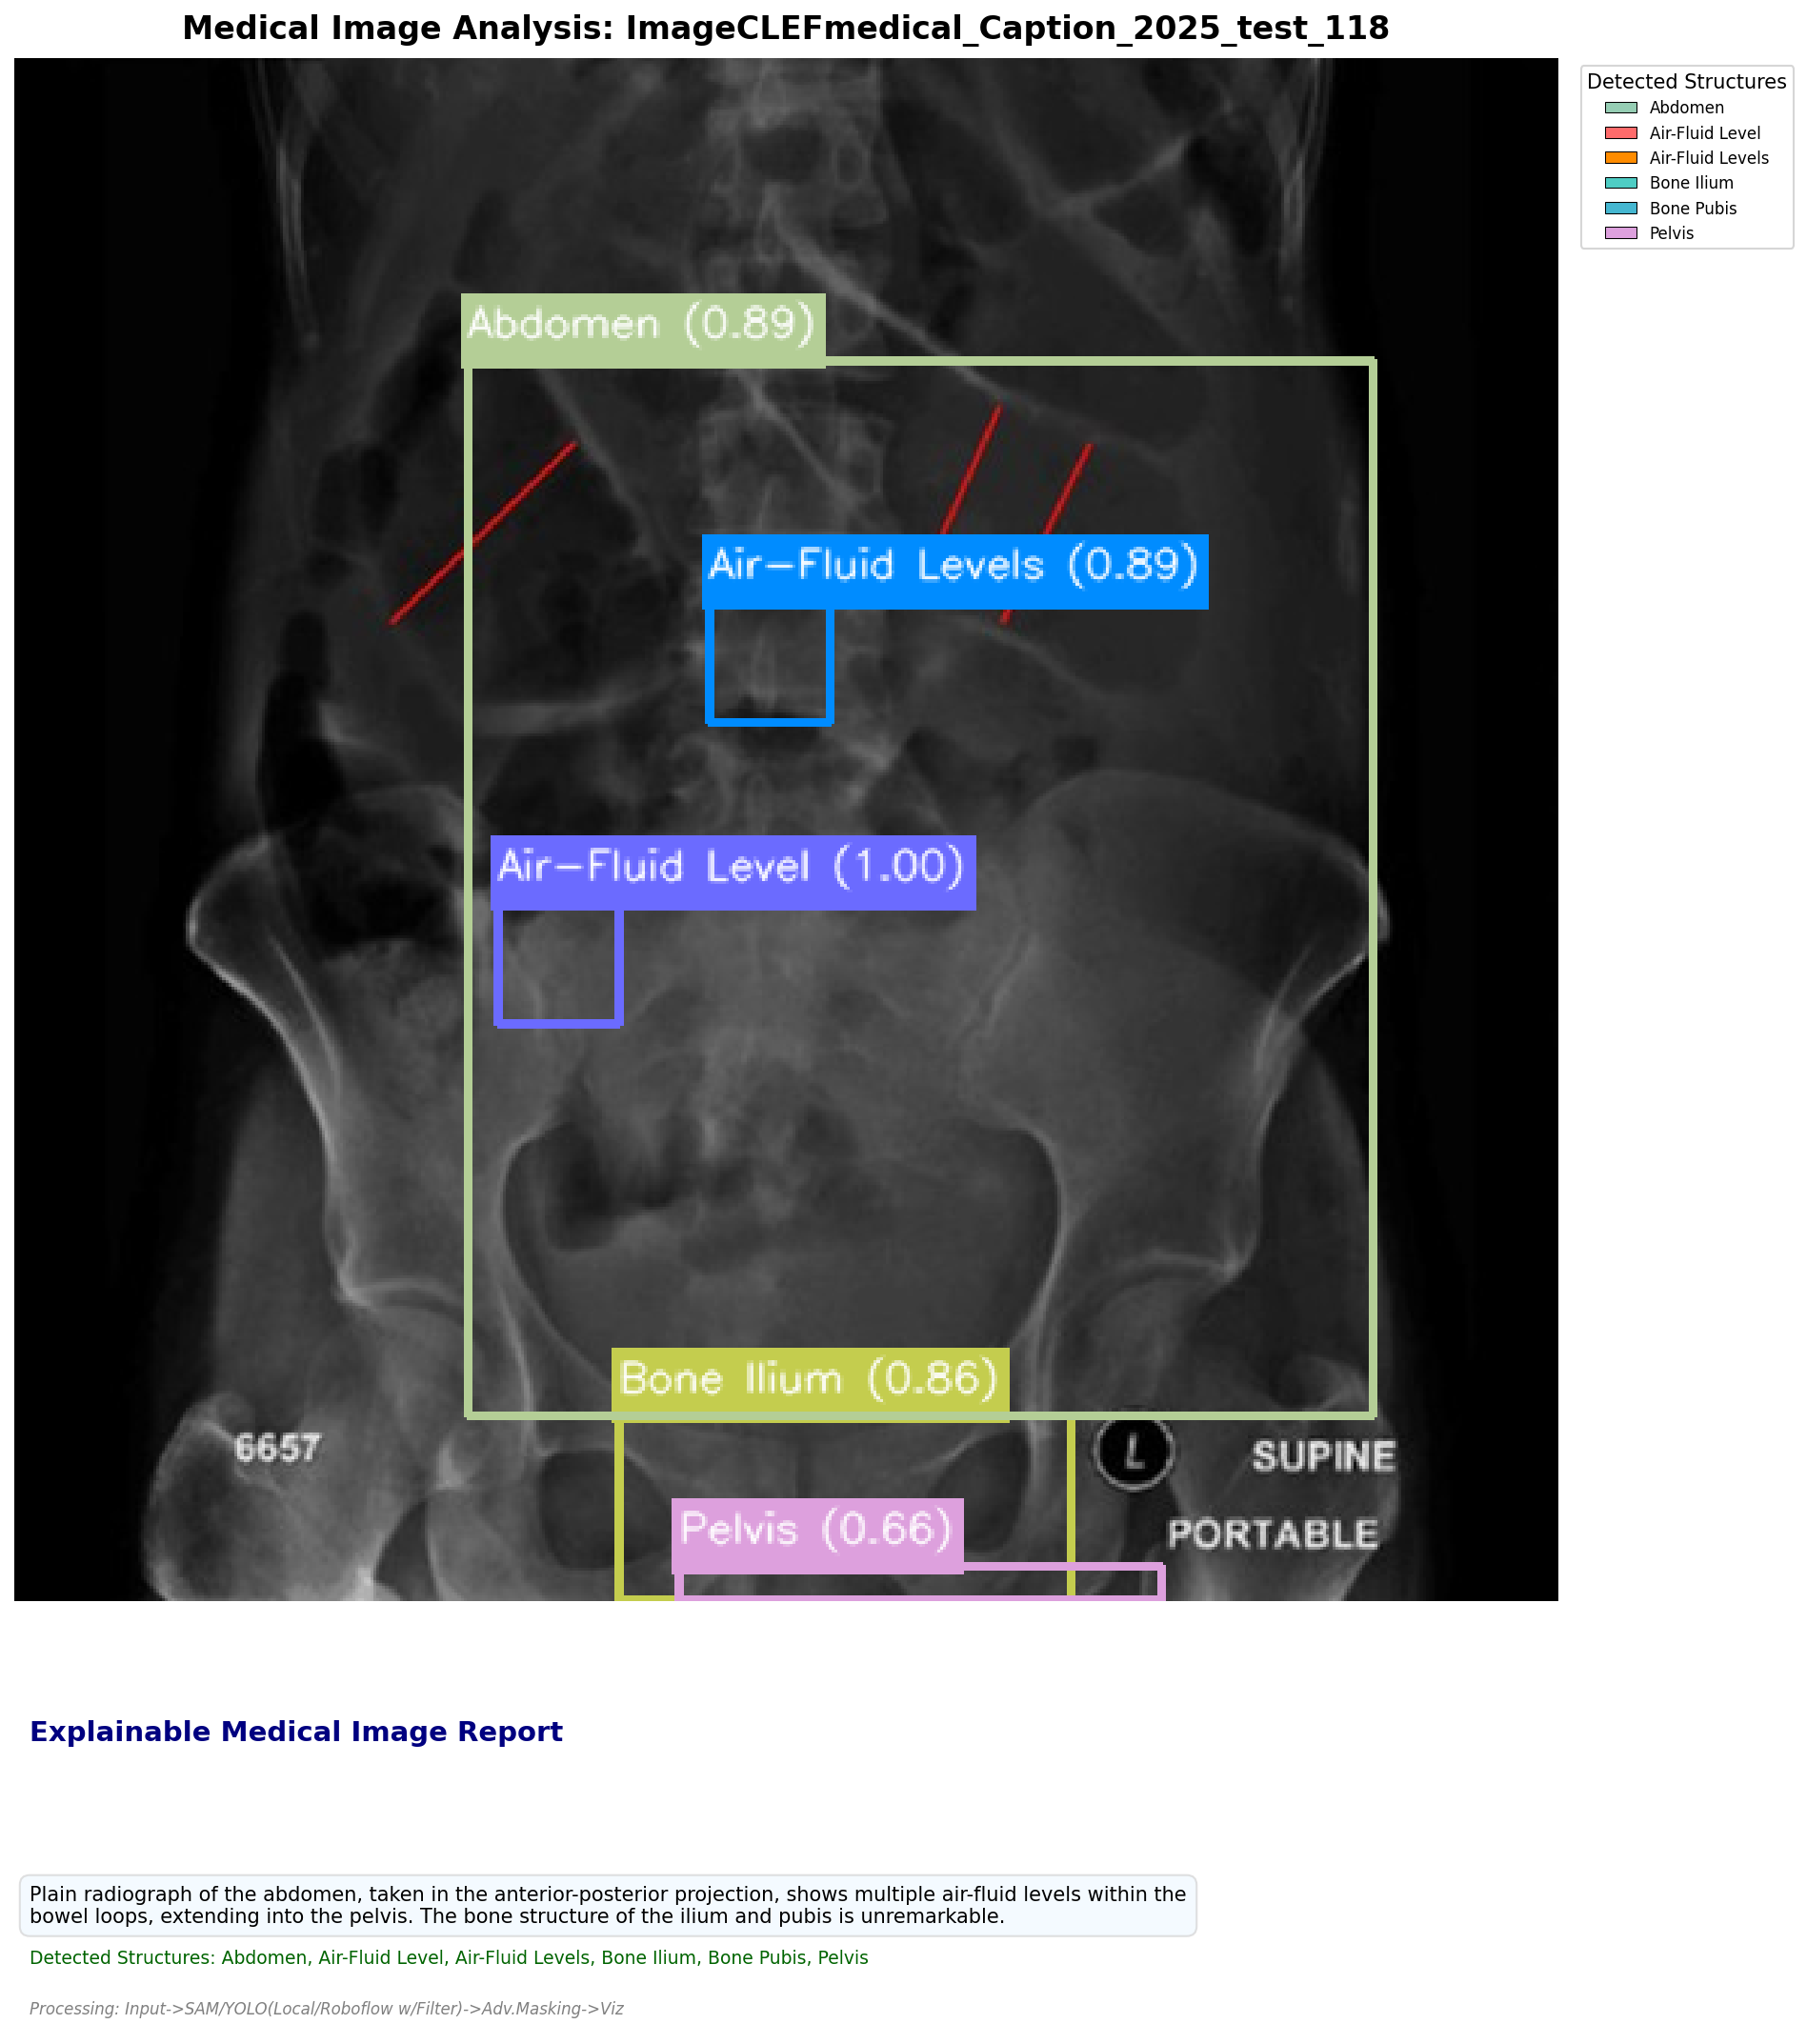


Viz for Image ID: ImageCLEFmedical_Caption_2025_test_1251 (Path: ./result_explain-3/results_explain-9/main_visualizations/ImageCLEFmedical_Caption_2025_test_1251_main_analysis_20250524_001728.png)


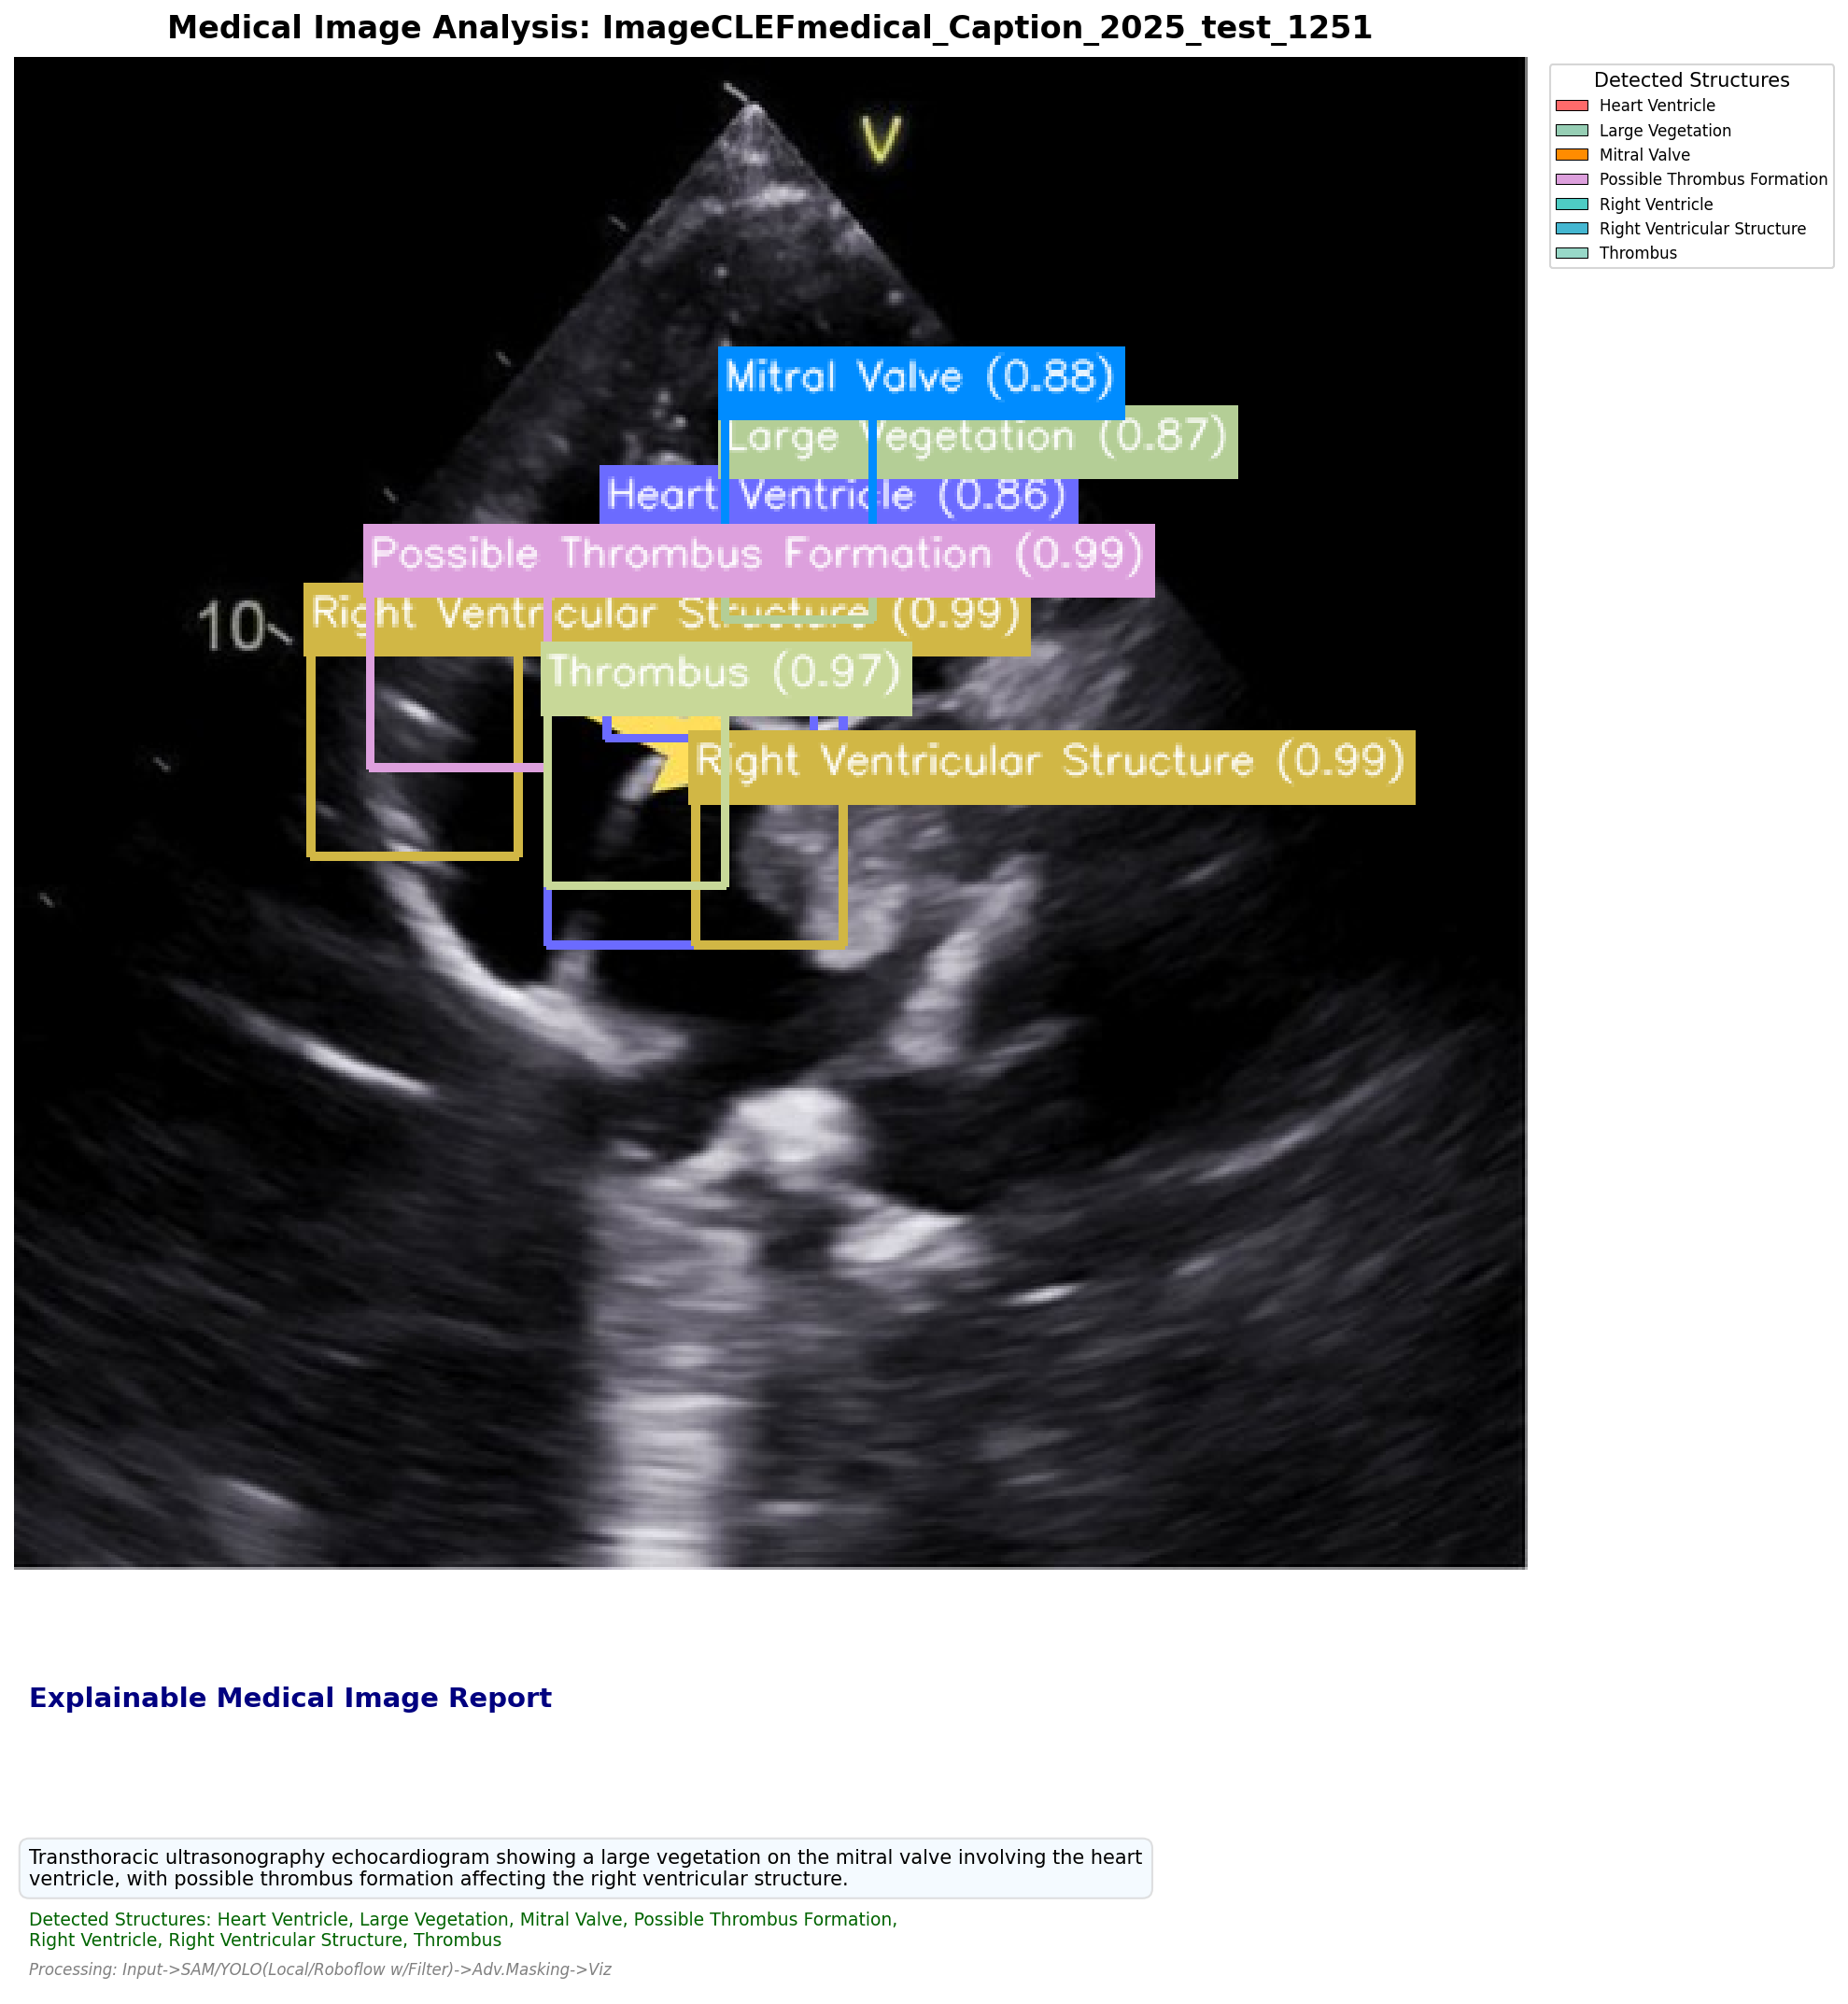


Viz for Image ID: ImageCLEFmedical_Caption_2025_test_1258 (Path: ./result_explain-3/results_explain-9/main_visualizations/ImageCLEFmedical_Caption_2025_test_1258_main_analysis_20250524_001752.png)


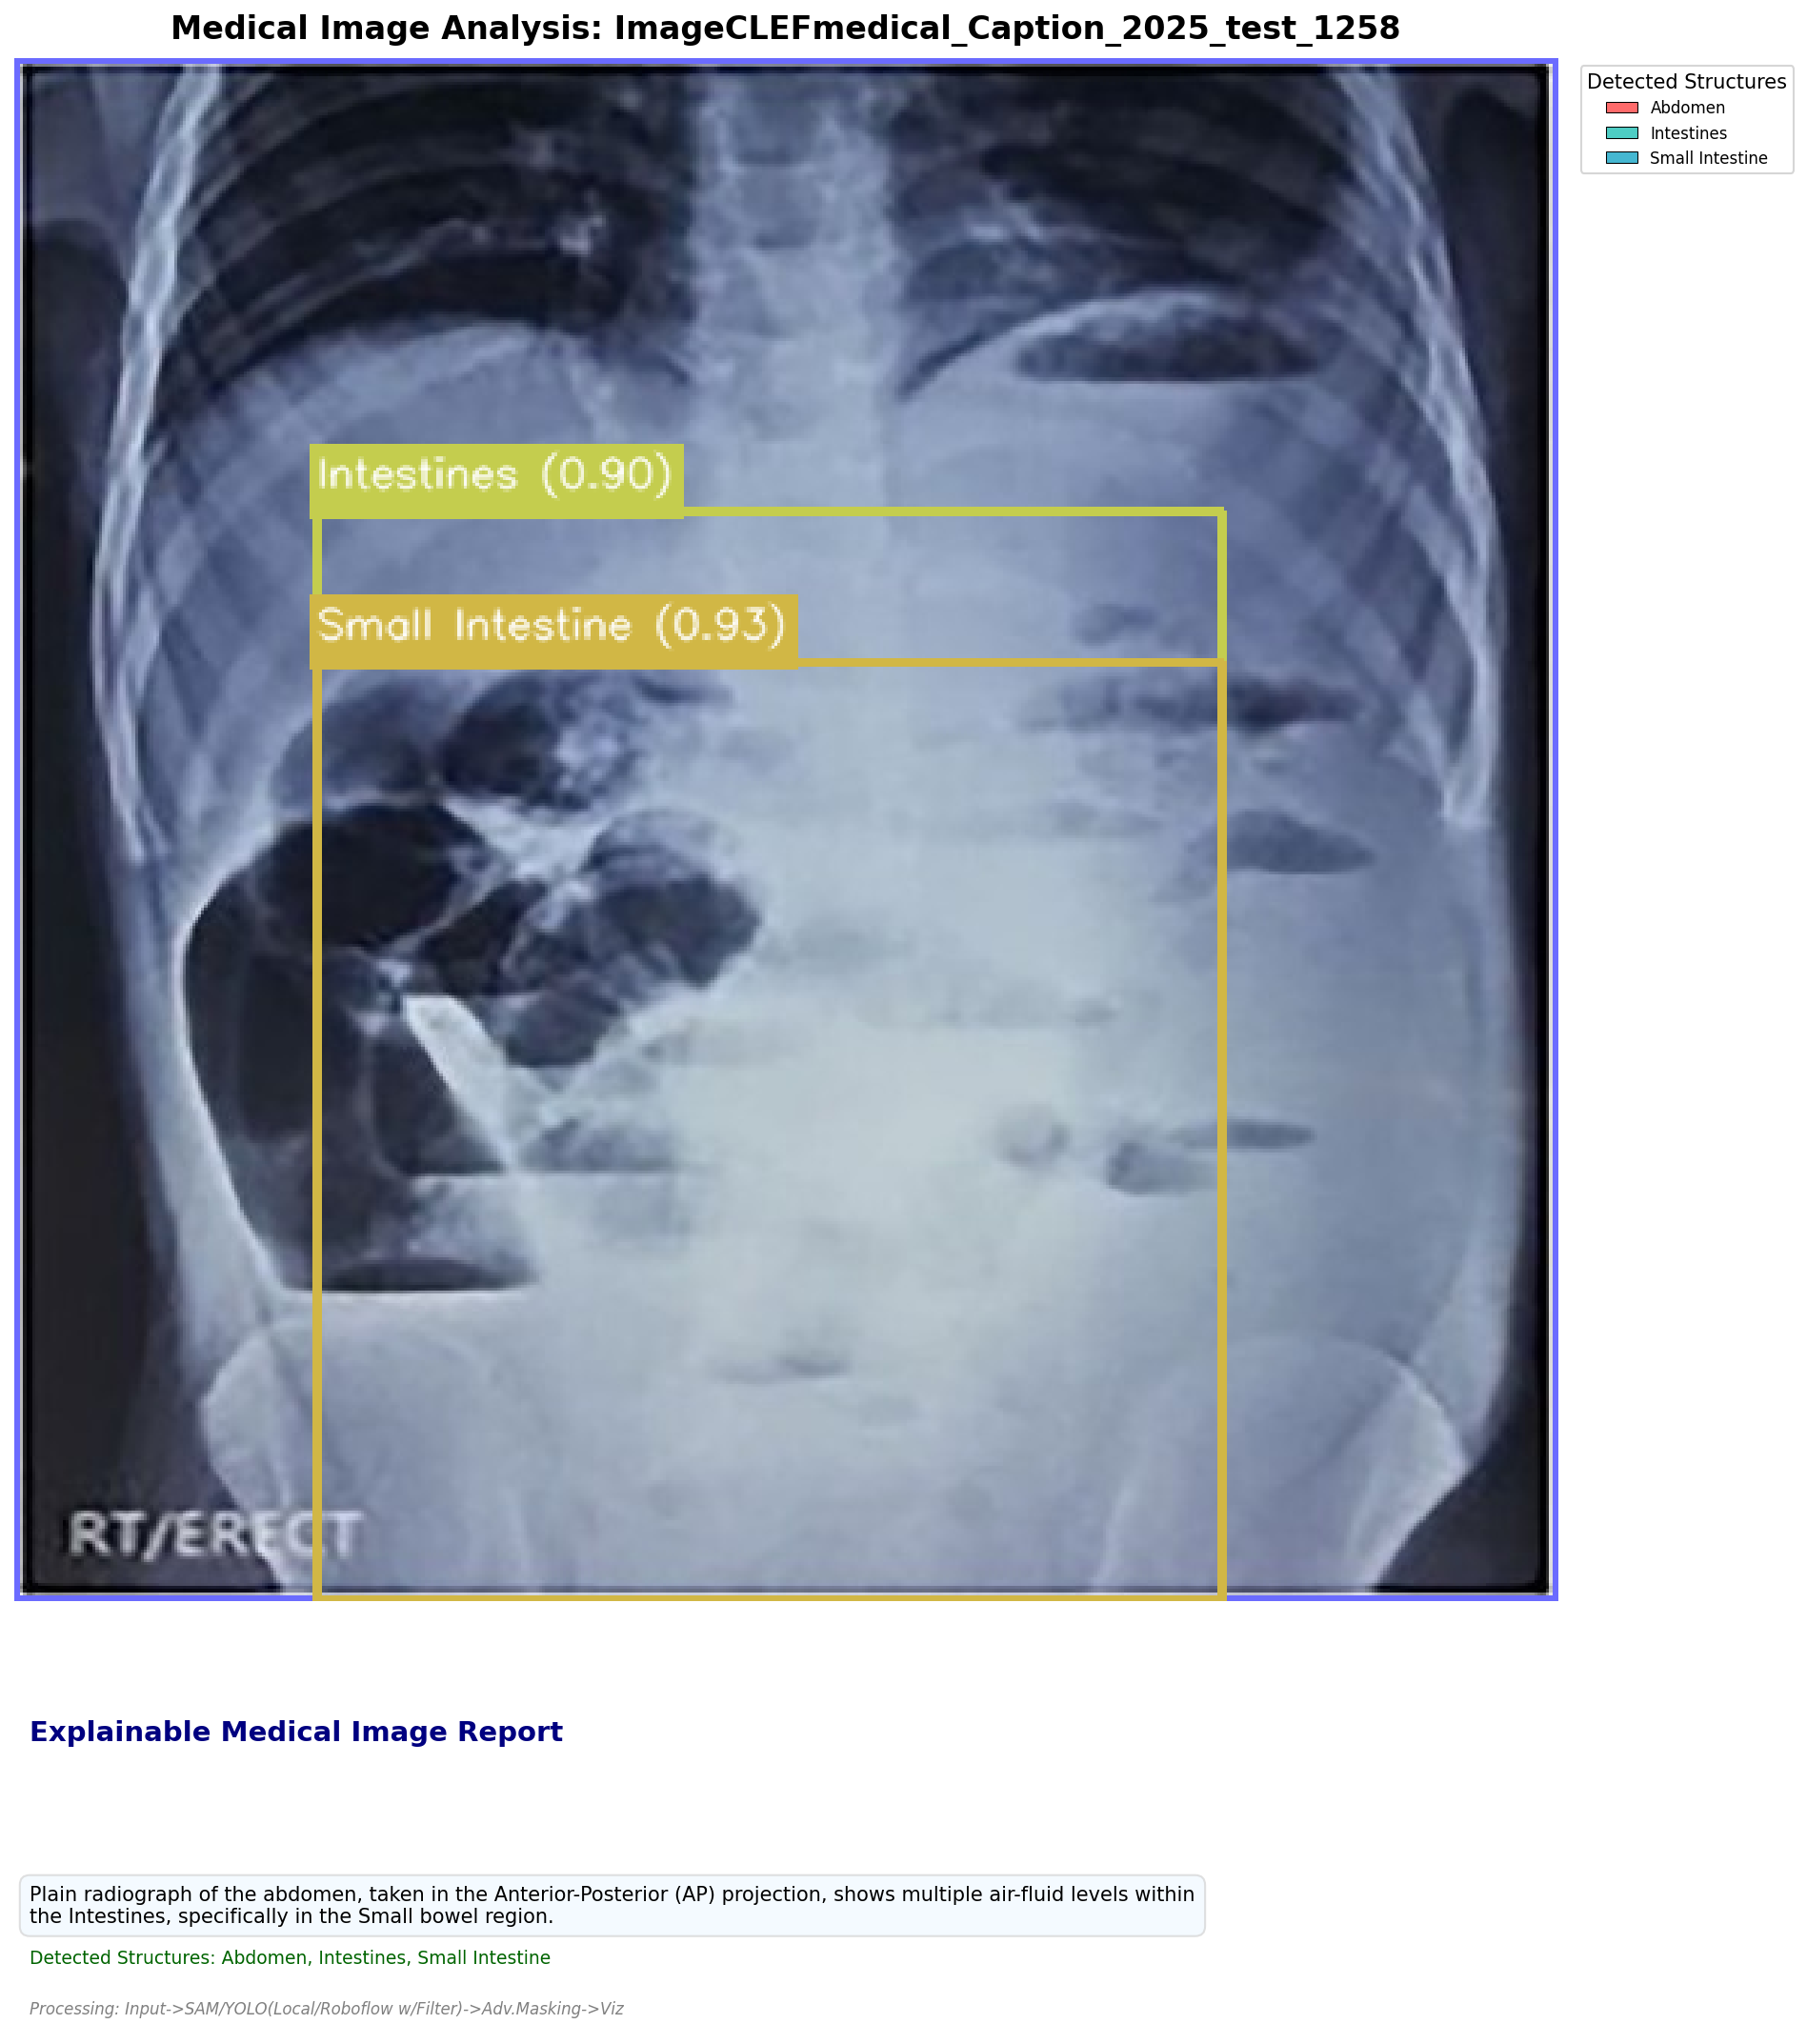


--- Analysis Metrics Summaries (from ./result_explain-3/results_explain-9/analysis_metrics) ---

--- Detailed Confidence (detailed_confidence.csv) ---
Loaded detailed_confidence.csv. Shape: (67, 4)
Top 5 rows:
                                 image_id         structure  confidence_score                 strategy
0  ImageCLEFmedical_Caption_2025_test_118   Air-Fluid Level          0.996245                  kp_fast
1  ImageCLEFmedical_Caption_2025_test_118        Bone Ilium          0.858698  orig_bbox(bbox_success)
2  ImageCLEFmedical_Caption_2025_test_118        Bone Pubis          0.681468  orig_bbox(bbox_success)
3  ImageCLEFmedical_Caption_2025_test_118           Abdomen          0.892184  orig_bbox(bbox_success)
4  ImageCLEFmedical_Caption_2025_test_118  Air-Fluid Levels          0.894134  orig_bbox(bbox_success)

--- Image Summary (image_summary.csv) ---
Loaded image_summary.csv. Shape: (16, 4)
Top 5 rows:
                                   image_id  structures_count  avg_confiden

In [ ]:
# ==============================================================================
# SECTION I: IMPORTS, CONFIGURATION, AND INITIAL SETUP
# ==============================================================================
print("----------------------------------------------------------------------")
print("SECTION I: INITIALIZING LIBRARIES, CONFIGURATION, AND CUDA")
print("----------------------------------------------------------------------")

# Standard Libraries
import os
import gc  # Garbage collection
import time  # For adding pauses
import json
import re
import warnings
import urllib.request
from collections import defaultdict
import csv  # Though pandas is used more for CSVs later
import logging  # For more structured logging if desired
from datetime import datetime
import traceback

# Data Handling & Numerics
import pandas as pd
import numpy as np

# Image Processing
import cv2
from scipy import ndimage
from dotenv import load_dotenv
from skimage.measure import label as skimage_label, regionprops
from scipy.spatial.distance import euclidean

try:
    from skimage import feature

    SKIMAGE_AVAILABLE = True
    print("Scikit-image (skimage) available.")
except ImportError:
    SKIMAGE_AVAILABLE = False
    print(
        "Scikit-image (skimage) not available. Some keypoint features will be disabled."
    )

# Plotting & Visualization
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from matplotlib.patches import Rectangle
from mpl_toolkits.mplot3d import Axes3D  # For 3D heatmap
import textwrap  # For wrapping text in visualizations

# Machine Learning & Deep Learning - PyTorch & Transformers
import torch
from segment_anything import sam_model_registry, SamAutomaticMaskGenerator, SamPredictor

try:
    import ultralytics

    YOLO_AVAILABLE = True  # For local YOLO
    print("Ultralytics YOLO available.")
except ImportError:
    YOLO_AVAILABLE = False
    print("Ultralytics YOLO not available. Local YOLO enhancement will be disabled.")

# --- REFACTORED: Added Roboflow SDK Import ---
try:
    from inference_sdk import InferenceHTTPClient

    ROBOFLOW_SDK_AVAILABLE = True
    print("Roboflow Inference SDK available.")
except ImportError:
    ROBOFLOW_SDK_AVAILABLE = False
    print(
        "Roboflow Inference SDK not available. Roboflow YOLO fallback/addition will be disabled."
    )


# IPython/Jupyter specific
from IPython.display import display, Image as IPImage

# --- Configuration ---
print("\n--- Loading Configuration ---")
SAM_COORD_PATH = "./sam_coord.csv"
CAPTIONS_PATH = "./3_submission_explainability.csv"
CONCEPTS_PATH = "./ref_mini_concepts_natural_.csv"
CAPTION_FILE_PATH = "./caption.csv"
IMAGES_DIR = "./data/test_set_explain"
OUTPUT_DIR = "./result_explain-3/results_explain-9"

os.makedirs(OUTPUT_DIR, exist_ok=True)
print(f"✓ Output directory set to: {OUTPUT_DIR}")

COLORS = [
    "#FF6B6B",
    "#4ECDC4",
    "#45B7D1",
    "#96CEB4",
    "#FF8C00",
    "#DDA0DD",
    "#98D8C8",
    "#F7DC6F",
    "#BB8FCE",
    "#85C1E9",
    "#F8C471",
    "#82E0AA",
    "#F1948A",
    "#85C1E9",
    "#D5DBDB",
]
print(f"✓ Color palette loaded with {len(COLORS)} colors.")

warnings.filterwarnings("ignore")
print("✓ Warnings are suppressed (set to 'ignore').")

# --- REFACTORED: Roboflow Configuration ---
ROBOFLOW_API_URL = "https://serverless.roboflow.com"
ROBOFLOW_API_KEY = api_key = os.getenv("ROBOFLOW_API_KEY") # Replace with your actual key if different, or better, load from env
ROBOFLOW_MODEL_ID = "yolo-based-model-for-medical-image-analysis/1"
ROBOFLOW_CLIENT = None  # Will be initialized if SDK is available and key is set

if (
    ROBOFLOW_SDK_AVAILABLE
    and ROBOFLOW_API_KEY
    and ROBOFLOW_API_KEY != "YOUR_ROBOFLOW_API_KEY_HERE"
):  # Basic check
    try:
        ROBOFLOW_CLIENT = InferenceHTTPClient(
            api_url=ROBOFLOW_API_URL, api_key=ROBOFLOW_API_KEY
        )
        print(f"✓ Roboflow client initialized for model: {ROBOFLOW_MODEL_ID}")
    except Exception as e:
        print(f"Failed to initialize Roboflow client: {e}")
        ROBOFLOW_CLIENT = None  # Ensure it's None if initialization fails
elif ROBOFLOW_SDK_AVAILABLE and (
    not ROBOFLOW_API_KEY or ROBOFLOW_API_KEY == "YOUR_ROBOFLOW_API_KEY_HERE"
):
    print("Roboflow API key not set. Roboflow YOLO functionality will be disabled.")
    ROBOFLOW_CLIENT = None


def clear_cuda_cache():
    if torch.cuda.is_available():
        print("Clearing CUDA cache...")
        torch.cuda.empty_cache()
        torch.cuda.synchronize()
        gc.collect()
        print("CUDA cache cleared.")
    else:
        print("CUDA not available, skipping cache clear.")


clear_cuda_cache()

# ==============================================================================
# SECTION II: CORE UTILITIES & EARLY VISUALIZATION DEFINITIONS
# ==============================================================================
# ... (This section remains the same as your last version, including moved heatmap functions) ...
print("\n----------------------------------------------------------------------")
print("SECTION II: DEFINING CORE UTILITIES & EARLY VISUALIZATION DEFINITIONS")
print("----------------------------------------------------------------------")


def hex_to_rgb(hex_color):
    hex_color = hex_color.lstrip("#")
    return [int(hex_color[i : i + 2], 16) / 255.0 for i in (0, 2, 4)]


# --- Heatmap Generation (Moved Earlier & Corrected) ---
def generate_useful_heatmap_analysis(
    image_rgb,
    bbox_coords,
    mask_array,
    confidence_score,
    label_text,
    image_id_str,
    base_output_dir,
):
    """
    Generates and SAVES a 4-panel analysis image: Original+BBox, Detected Mask, Mask Overlay, ROI.
    CORRECTED: Blending logic for Panel 3 (Mask Overlay) to fix OpenCV arithm_op error.
    """
    try:
        x, y, w, h = map(int, bbox_coords)
        heatmap_output_dir = os.path.join(
            base_output_dir, "heatmaps_and_masks", str(image_id_str)
        )
        os.makedirs(heatmap_output_dir, exist_ok=True)

        fig, axes = plt.subplots(2, 2, figsize=(12, 10))
        fig.suptitle(
            f"Mask Analysis: {image_id_str} - {label_text}\n(SAM Conf: {confidence_score:.3f})",
            fontsize=14,
        )  # Clarified Conf source

        # 1. Original image with BBox
        axes[0, 0].imshow(image_rgb)
        rect_patch = Rectangle(
            (x, y), w, h, linewidth=2, edgecolor="red", facecolor="none"
        )
        axes[0, 0].add_patch(rect_patch)
        axes[0, 0].set_title("Original Image + BBox")
        axes[0, 0].axis("off")

        # 2. Detected Mask
        axes[0, 1].imshow(
            mask_array, cmap="viridis"
        )  # 'viridis' is often good for masks
        axes[0, 1].set_title(f"Detected SAM Mask")
        axes[0, 1].axis("off")

        # 3. Mask Overlay on image (CORRECTED BLENDING)
        overlay_img_panel3 = image_rgb.copy()
        boolean_mask_panel3 = mask_array.astype(bool)

        overlay_color_rgb_panel3 = np.array([255, 0, 0], dtype=image_rgb.dtype)  # Red

        # Extract original pixels from the image where the mask is True
        original_pixels_in_mask = image_rgb[boolean_mask_panel3]

        # Perform blending using NumPy array arithmetic for robustness
        if original_pixels_in_mask.size > 0:  # Proceed only if mask is not empty
            blended_pixels = (
                0.6 * original_pixels_in_mask + 0.4 * overlay_color_rgb_panel3
            ).astype(
                image_rgb.dtype
            )  # Adjusted weights for less intense red
            overlay_img_panel3[boolean_mask_panel3] = blended_pixels

        axes[1, 0].imshow(overlay_img_panel3)
        axes[1, 0].set_title("Mask Overlay")
        axes[1, 0].axis("off")

        # 4. Region of Interest (ROI) from original image
        roi_x_end = min(x + w, image_rgb.shape[1])
        roi_y_end = min(y + h, image_rgb.shape[0])
        roi_x_start = max(0, x)
        roi_y_start = max(0, y)

        if roi_x_end > roi_x_start and roi_y_end > roi_y_start:
            roi_img = image_rgb[roi_y_start:roi_y_end, roi_x_start:roi_x_end]
            axes[1, 1].imshow(roi_img)
        else:
            axes[1, 1].text(0.5, 0.5, "Invalid ROI dims", ha="center", va="center")
        axes[1, 1].set_title("Region of Interest (BBox)")
        axes[1, 1].axis("off")

        plt.tight_layout(rect=[0, 0, 1, 0.96])  # Adjust for suptitle

        safe_label_text = "".join(c if c.isalnum() else "_" for c in label_text)
        # Added timestamp to filename to avoid overwrites if the script is run multiple times
        # or if labels are processed very quickly leading to same-second saves.
        heatmap_filename = (
            f"mask_analysis_{image_id_str}_{safe_label_text}_{int(time.time())}.png"
        )
        heatmap_save_path = os.path.join(heatmap_output_dir, heatmap_filename)

        plt.savefig(
            heatmap_save_path, dpi=100
        )  # Lower DPI for individual diagnostic images
        plt.close(fig)  # Close the figure to free memory and prevent display
        print(f"Saved MASK analysis heatmap: {heatmap_save_path}")

    except Exception as e:
        print(
            f"Error generating 'useful heatmap analysis' for {label_text} on {image_id_str}: {e}"
        )
        import traceback  # Ensure traceback is imported for detailed error

        traceback.print_exc()
        if "fig" in locals() and fig is not None:  # Ensure figure is closed on error
            plt.close(fig)


def generate_comprehensive_heatmap_display(
    image_rgb,
    bbox_coords,
    mask_array,
    confidence_score,
    label_text,
    image_id_str,
    base_output_dir,
    show_plot=False,
):
    try:
        x, y, w, h = map(int, bbox_coords)
        heatmap_output_dir = os.path.join(
            base_output_dir, "detailed_heatmaps", str(image_id_str)
        )
        os.makedirs(heatmap_output_dir, exist_ok=True)
        fig = plt.figure(figsize=(15, 12))
        fig.suptitle(
            f"Detailed Heatmap: {image_id_str} - {label_text}\n(Conf: {confidence_score:.3f})",
            fontsize=16,
        )
        ax1 = fig.add_subplot(2, 2, 1)
        ax1.imshow(image_rgb)
        ax1.add_patch(Rectangle((x, y), w, h, lw=3, ec="cyan", fc="none"))
        ax1.set_title("Original + BBox")
        ax1.axis("off")
        ax2 = fig.add_subplot(2, 2, 2)
        prob_map = np.zeros(image_rgb.shape[:2])
        cx, cy = x + w // 2, y + h // 2
        Y, X = np.mgrid[0 : image_rgb.shape[0], 0 : image_rgb.shape[1]]
        sx, sy = max(1, w / 4.0), max(1, h / 4.0)
        dist_sq = ((X - cx) / sx) ** 2 + ((Y - cy) / sy) ** 2
        prob_map_raw = confidence_score * np.exp(-dist_sq / 2.0)
        if mask_array.shape == prob_map_raw.shape:
            prob_map = prob_map_raw * mask_array.astype(float)
        else:
            prob_map = prob_map_raw
        im = ax2.imshow(prob_map, cmap="hot", vmin=0, vmax=max(0.01, confidence_score))
        ax2.set_title("Conceptual Heatmap (Masked)")
        ax2.axis("off")
        plt.colorbar(im, ax=ax2, fraction=0.046, pad=0.04).set_label("Prob.")
        ax3 = fig.add_subplot(2, 2, 3)
        overlay = image_rgb.astype(float) / 255.0
        cmap_hot = plt.get_cmap("hot")
        prob_norm = prob_map / (confidence_score + 1e-6)
        for c in range(3):
            overlay[:, :, c] = (
                overlay[:, :, c] * (1 - prob_norm * 0.7)
                + cmap_hot(prob_norm)[:, :, c] * prob_norm * 0.7
            )
        ax3.imshow(np.clip(overlay, 0, 1))
        ax3.set_title("Heatmap Overlay (Masked)")
        ax3.axis("off")
        ax4 = fig.add_subplot(2, 2, 4, projection="3d")
        rx, ry = np.arange(
            max(0, x - w // 2), min(image_rgb.shape[1], x + w + w // 2)
        ), np.arange(max(0, y - h // 2), min(image_rgb.shape[0], y + h + h // 2))
        if len(rx) > 1 and len(ry) > 1:
            GX, GY = np.meshgrid(rx, ry)
            GZ = prob_map[GY, GX]
            ax4.plot_surface(GX, GY, GZ, cmap="hot", edgecolor="none", alpha=0.8)
            ax4.set_title("3D Heatmap (Masked)")
        else:
            ax4.text(0.5, 0.5, 0.5, "ROI small for 3D")
        plt.tight_layout(rect=[0, 0, 1, 0.95])
        safe_lbl = "".join(c if c.isalnum() else "_" for c in label_text)
        fname = f"detailed_heatmap_{image_id_str}_{safe_lbl}_{int(time.time())}.png"
        plt.savefig(os.path.join(heatmap_output_dir, fname), dpi=150)
        if show_plot:
            plt.show()
        plt.close(fig)
        print(
            f"  ✓ Saved DETAILED conceptual heatmap: {os.path.join(heatmap_output_dir,fname)}"
        )
    except Exception as e:
        print(f"Error in generate_comprehensive_heatmap_display for {label_text}: {e}")
        if "fig" in locals() and fig is not None:
            plt.close(fig)


def load_data():
    # (Content remains the same)
    print("--- Loading CSV Data Files ---")
    data_loaded_successfully = True
    try:
        sam_df = pd.read_csv(SAM_COORD_PATH)
        print(f"✓ SAM coordinates loaded: {len(sam_df)} records")
    except Exception as e:
        print(f"ERROR SAM_COORD_PATH: {e}")
        sam_df = pd.DataFrame()
        data_loaded_successfully = False
    try:
        explanations_df = pd.read_csv(CAPTIONS_PATH)
        print(f"✓ Explanations loaded: {len(explanations_df)} records")
    except Exception as e:
        print(f"ERROR CAPTIONS_PATH: {e}")
        explanations_df = pd.DataFrame()
        data_loaded_successfully = False
    try:
        concepts_df = (
            pd.read_csv(CONCEPTS_PATH)
            if os.path.exists(CONCEPTS_PATH)
            else pd.DataFrame()
        )
        print(f"✓ Concepts loaded: {len(concepts_df)} records")
    except Exception as e:
        print(f"ERROR CONCEPTS_PATH: {e}")
        concepts_df = pd.DataFrame()
        data_loaded_successfully = False
    try:
        caption_file_df = (
            pd.read_csv(CAPTION_FILE_PATH)
            if os.path.exists(CAPTION_FILE_PATH)
            else pd.DataFrame()
        )
        print(f"✓ Caption file loaded: {len(caption_file_df)} records")
    except Exception as e:
        print(f"ERROR CAPTION_FILE_PATH: {e}")
        caption_file_df = pd.DataFrame()
        data_loaded_successfully = False
    if not data_loaded_successfully:
        print("⚠️ Some data files failed to load.")
    return sam_df, explanations_df, concepts_df, caption_file_df


def find_image_file(image_id, images_dir):
    # (Content remains the same)
    extensions = [".jpg", ".jpeg", ".png", ".bmp", ".tiff", ".tif"]
    base_id = str(image_id).split(".")[0]
    for ext in extensions:
        path = os.path.join(images_dir, f"{base_id}{ext}")
        if os.path.exists(path):
            return path
    for root, _, files in os.walk(images_dir):
        for file in files:
            if os.path.splitext(file)[0] == base_id:
                return os.path.join(root, file)
    print(f"Could not find image for ID: {image_id} in {images_dir}")
    return None


def clean_label_text(label):
    # (Content remains the same)
    if not isinstance(label, str):
        label = str(label)
    remove = ["Structure of", "Bone structure of", "Entire", "Complete"]
    for term in remove:
        label = re.sub(r"(?i)\b" + re.escape(term) + r"\s*", "", label)
    return label.strip().title()


print("✓ Core utility & early visualization functions defined.")

# ==============================================================================
# SECTION III: SEGMENT ANYTHING MODEL (SAM) SETUP
# ==============================================================================
# ... (This section remains the same) ...
print("\n----------------------------------------------------------------------")
print("SECTION III: SETTING UP SEGMENT ANYTHING MODEL (SAM)")
print("----------------------------------------------------------------------")


def setup_sam():  # (Content from your script)
    print("--- Initializing SAM ---")
    try:
        os.makedirs("sam_models", exist_ok=True)
        sam_checkpoint = "sam_models/sam_vit_h_4b8939.pth"
        model_type = "vit_h"
        if not os.path.exists(sam_checkpoint):
            print(f"SAM checkpoint downloading...")
            urllib.request.urlretrieve(
                "https://dl.fbaipublicfiles.com/segment_anything/sam_vit_h_4b8939.pth",
                sam_checkpoint,
            )
            print("✓ SAM model downloaded.")
        device_type = "cuda" if torch.cuda.is_available() else "cpu"
        print(f"Attempting SAM on device: {device_type}")
        try:
            sam_model = sam_model_registry[model_type](checkpoint=sam_checkpoint)
            sam_model.to(device=device_type)
            predictor = SamPredictor(sam_model)
            print(f"✓ SAM model ({model_type}) loaded on {device_type}!")
            return predictor, device_type, sam_model
        except Exception as e:
            print(f"CUDA SAM loading failed: {e}. Fallback to CPU.")
            if device_type == "cuda":
                device_type = "cpu"
                sam_model = sam_model_registry[model_type](checkpoint=sam_checkpoint)
                sam_model.to(device=device_type)
                predictor = SamPredictor(sam_model)
                print(f"✓ SAM model ({model_type}) loaded on CPU (fallback)!")
                return predictor, device_type, sam_model
            else:
                print(f"SAM model loading failed on CPU: {e}")
                return None, "cpu", None
    except Exception as e:
        print(f"SAM setup failed: {e}")
        return None, "cpu", None


print("✓ SAM setup function defined.")

# ==============================================================================
# SECTION IV: SAM MASKING FUNCTIONS
# ==============================================================================
# ... (This section remains the same) ...
print("\n----------------------------------------------------------------------")
print("SECTION IV: DEFINING SAM MASKING LOGIC")
print("----------------------------------------------------------------------")


def get_sam_mask_from_bbox(
    image_rgb, bbox_coords, predictor
):  # (Content from your script)
    if predictor is None:
        return np.zeros(image_rgb.shape[:2], dtype=bool), 0.0, "predictor_unavailable"
    x, y, w, h = bbox_coords
    if x < 0 or y < 0 or w <= 0 or h <= 0:
        return np.zeros(image_rgb.shape[:2], dtype=bool), 0.0, "invalid_bbox"
    try:
        predictor.set_image(image_rgb)
    except Exception as e:
        return np.zeros(image_rgb.shape[:2], dtype=bool), 0.0, f"set_image_failed:{e}"
    input_box = np.array([x, y, x + w, y + h])
    try:
        masks, scores, _ = predictor.predict(
            box=input_box[None, :], multimask_output=True
        )
        if (
            masks is not None
            and len(masks) > 0
            and scores is not None
            and len(scores) > 0
        ):
            best_idx = np.argmax(scores)
            return masks[best_idx], float(scores[best_idx]), "bbox_success"
        return np.zeros(image_rgb.shape[:2], dtype=bool), 0.0, "no_masks_from_bbox"
    except RuntimeError as e:
        if "CUDA out of memory" in str(e):
            clear_cuda_cache()
        return (
            np.zeros(image_rgb.shape[:2], dtype=bool),
            0.0,
            f"prediction_runtime_error:{e}",
        )
    except Exception as e:
        return np.zeros(image_rgb.shape[:2], dtype=bool), 0.0, f"prediction_error:{e}"


def get_sam_mask_from_points(
    image_rgb, points_coords, predictor, point_labels=None
):  # (Content from your script)
    if predictor is None:
        return np.zeros(image_rgb.shape[:2], dtype=bool), 0.0
    if point_labels is None:
        point_labels = np.ones(len(points_coords))
    try:
        predictor.set_image(image_rgb)
    except Exception:
        return np.zeros(image_rgb.shape[:2], dtype=bool), 0.0
    try:
        masks, scores, _ = predictor.predict(
            point_coords=np.array(points_coords),
            point_labels=np.array(point_labels),
            multimask_output=True,
        )
        if (
            masks is not None
            and len(masks) > 0
            and scores is not None
            and len(scores) > 0
        ):
            best_idx = np.argmax(scores)
            return masks[best_idx], float(scores[best_idx])
        return np.zeros(image_rgb.shape[:2], dtype=bool), 0.0
    except RuntimeError as e:
        if "CUDA out of memory" in str(e):
            clear_cuda_cache()
        return np.zeros(image_rgb.shape[:2], dtype=bool), 0.0
    except Exception:
        return np.zeros(image_rgb.shape[:2], dtype=bool), 0.0


print("SAM masking functions defined.")

# ==============================================================================
# SECTION V: KEYPOINT & ARROW DETECTION
# ==============================================================================

print("\n----------------------------------------------------------------------")
print("SECTION V: DEFINING KEYPOINT AND ARROW DETECTION LOGIC")
print("----------------------------------------------------------------------")


def detect_keypoints_and_regions(image_rgb, bbox_coords):  # (Content from your script)
    x, y, w, h = map(int, bbox_coords)
    img_h, img_w = image_rgb.shape[:2]
    if x < 0 or y < 0 or w <= 0 or h <= 0 or x + w > img_w or y + h > img_h:
        return []
    roi = image_rgb[y : y + h, x : x + w]
    gray_roi = cv2.cvtColor(roi, cv2.COLOR_RGB2GRAY)
    regions = []
    try:
        sift = cv2.SIFT_create()
        kp = sift.detect(gray_roi, None)
        if kp:
            regions.append(
                (
                    "sift",
                    np.array([[k.pt[0] + x, k.pt[1] + y] for k in kp[:10]], dtype=int),
                )
            )
    except Exception:
        pass
    if SKIMAGE_AVAILABLE:
        try:
            blobs = feature.blob_log(
                gray_roi, max_sigma=20, min_sigma=5, num_sigma=5, threshold=0.05
            )
            if blobs.size > 0:
                regions.append(
                    (
                        "log_blobs",
                        np.array([[b[1] + x, b[0] + y] for b in blobs[:5]], dtype=int),
                    )
                )
        except Exception:
            pass
    try:
        fast = cv2.FastFeatureDetector_create(threshold=10)
        kp = fast.detect(gray_roi, None)
        if kp:
            regions.append(
                (
                    "fast",
                    np.array([[k.pt[0] + x, k.pt[1] + y] for k in kp[:8]], dtype=int),
                )
            )
    except Exception:
        pass
    return regions


def advanced_arrow_detection(
    image_rgb, bbox_coords, debug=False
):  
    x, y, w, h = map(int, bbox_coords)
    img_h, img_w = image_rgb.shape[:2]
    info = {
        "found": False,
        "target_bbox": bbox_coords,
        "confidence": 0.0,
        "method": "none",
    }
    if x < 0 or y < 0 or w <= 0 or h <= 0 or x + w > img_w or y + h > img_h:
        return info
    roi = image_rgb[y : y + h, x : x + w]
    gray = cv2.cvtColor(roi, cv2.COLOR_RGB2GRAY)
    try:
        edges = cv2.Canny(gray, 50, 150, apertureSize=3)
        lines = cv2.HoughLinesP(
            edges,
            1,
            np.pi / 180,
            15,
            minLineLength=max(10, min(w, h) // 4),
            maxLineGap=max(5, min(w, h) // 10),
        )
        if lines is not None:
            lines_data = [
                (l[0], np.sqrt((l[0][2] - l[0][0]) ** 2 + (l[0][3] - l[0][1]) ** 2))
                for l in lines
            ]
            lines_data.sort(key=lambda item: item[1], reverse=True)
            if lines_data and lines_data[0][1] > min(w, h) * 0.25:
                lx1, ly1, lx2, ly2 = lines_data[0][0]
                length = lines_data[0][1]
                direction = np.array([lx2 - lx1, ly2 - ly1]) / length
                ef = length
                tx, ty = x + lx2 + direction[0] * ef, y + ly2 + direction[1] * ef
                bs = max(20, int(min(w, h) * 0.5))
                nx, ny = max(0, min(int(tx - bs // 2), img_w - bs)), max(
                    0, min(int(ty - bs // 2), img_h - bs)
                )
                info = {
                    "found": True,
                    "target_bbox": (nx, ny, bs, bs),
                    "confidence": min(length / max(1, max(w, h)), 1.0),
                    "method": "line_h",
                }
    except Exception as e:
        info["method"] = f"err:{e}"
    return info


def correct_directional_labels(
    label_text, bbox_coords, image_width
):  
    x, _, w, _ = bbox_coords
    center_x = x + w / 2.0
    img_side_left = center_x < image_width / 2.0
    corrected = label_text
    if "right" in label_text.lower() and not img_side_left:
        corrected = re.sub(r"(?i)right", "Left", label_text)
    elif "left" in label_text.lower() and img_side_left:
        corrected = re.sub(r"(?i)left", "Right", label_text)
    return corrected.title()


def sam_with_intelligent_arrow_following(
    image_rgb, bbox_coords, predictor, label_text, debug=False
):  
    mask, conf, strat_msg = get_sam_mask_from_bbox(image_rgb, bbox_coords, predictor)
    best_mask, best_conf, best_strategy = mask, conf, f"orig_bbox({strat_msg})"
    if best_conf < 0.75:  # Arrow
        arrow_info = advanced_arrow_detection(image_rgb, bbox_coords, debug)
        if arrow_info["found"] and arrow_info["target_bbox"] != bbox_coords:
            am, ac, astrat = get_sam_mask_from_bbox(
                image_rgb, arrow_info["target_bbox"], predictor
            )
            adj_ac = ac * (1.0 + arrow_info["confidence"] * 0.2)
            if adj_ac > best_conf:
                best_mask, best_conf, best_strategy = (
                    am,
                    adj_ac,
                    f"arrow_{arrow_info['method']}_{astrat}",
                )
    if best_conf < 0.80:  # Keypoints
        keypoint_regions = detect_keypoints_and_regions(image_rgb, bbox_coords)
        for r_type, pts_array in keypoint_regions:
            if pts_array.ndim == 2 and pts_array.shape[0] > 0:
                try:
                    km, kc = get_sam_mask_from_points(image_rgb, pts_array, predictor)
                    if kc > best_conf:
                        best_mask, best_conf, best_strategy = km, kc, f"kp_{r_type}"
                except Exception:
                    pass
    return best_mask, best_conf, best_strategy


def select_best_mask_for_label_advanced(
    image_rgb,
    bbox_coords,
    predictor,
    label_text,
    image_id_for_heatmaps=None,
    export_heatmaps_flag=True,
):  
    try:
        mask, confidence, strategy = sam_with_intelligent_arrow_following(
            image_rgb, bbox_coords, predictor, label_text, debug=True
        )
        if (
            export_heatmaps_flag
            and confidence > 0.6
            and image_id_for_heatmaps is not None
        ):
            generate_useful_heatmap_analysis(
                image_rgb,
                bbox_coords,
                mask,
                confidence,
                label_text,
                image_id_for_heatmaps,
                OUTPUT_DIR,
            )
        return mask, confidence, strategy
    except Exception as e:
        print(f"Err advanced_mask_selection for {label_text}:{e}")
        try:
            mask, confidence, strategy_msg = get_sam_mask_from_bbox(
                image_rgb, bbox_coords, predictor
            )
            return mask, confidence, f"fallback_bbox({strategy_msg})"
        except Exception as e2:
            print(f"Basic fallback SAM failed for {label_text}:{e2}")
            return np.zeros(image_rgb.shape[:2], dtype=bool), 0.0, "error_no_mask"


print("Keypoint, Arrow Detection, and Advanced Mask Selection functions defined.")

# ==============================================================================
# SECTION VI: YOLO ENHANCEMENT WITH SEMANTIC FILTERING & ROBOFLOW INTEGRATION
# ==============================================================================
print("\n----------------------------------------------------------------------")
print("SECTION VI: DEFINING YOLO ENHANCEMENT WITH SEMANTIC FILTERING & ROBOFLOW")
print("----------------------------------------------------------------------")

CLINICAL_VOCABULARY = {
    "abdomen",
    "air",
    "artery",
    "bone",
    "bowel",
    "brain",
    "breast",
    "bronchus",
    "calcification",
    "carina",
    "colon",
    "diaphragm",
    "effusion",
    "femur",
    "fluid",
    "gallbladder",
    "heart",
    "hilum",
    "humerus",
    "ilium",
    "intestine",
    "kidney",
    "lesion",
    "level",
    "liver",
    "lobe",
    "lung",
    "lymph",
    "mass",
    "mediastinum",
    "metal",
    "muscle",
    "nodule",
    "organ",
    "pancreas",
    "pelvis",
    "pleural",
    "pubis",
    "pulmonary",
    "rib",
    "sacrum",
    "scapula",
    "sinus",
    "soft",
    "spine",
    "spleen",
    "stent",
    "stomach",
    "structure",
    "thoracic",
    "thorax",
    "thyroid",
    "tissue",
    "trachea",
    "tube",
    "tumor",
    "vein",
    "vertebra",
    "vessel",
    "atelectasis",
    "cardiomegaly",
    "consolidation",
    "cyst",
    "edema",
    "embolism",
    "emphysema",
    "fracture",
    "hemorrhage",
    "hernia",
    "hypermetabolic",
    "hypoechoic",
    "infarct",
    "infiltrate",
    "metastasis",
    "opacity",
    "osteophyte",
    "pneumonia",
    "pneumothorax",
    "stenosis",
    "thickening",
    "air-fluid"  # Added to match example
    # Add more terms as needed
}
print(
    f"Clinical vocabulary loaded with {len(CLINICAL_VOCABULARY)} terms for YOLO filtering."
)


def is_label_clinically_relevant(label_text):
    label_words = set(
        label_text.lower().replace("-", " ").replace("_", " ").split()
    )  # Handle hyphens/underscores
    if not label_words.isdisjoint(CLINICAL_VOCABULARY):
        return True
    for term in CLINICAL_VOCABULARY:  # Check for substring matches
        if term in label_text.lower():
            return True
    return False


def calculate_bbox_iou(boxA, boxB):  # (Content from your script)
    b1_x1, b1_y1 = boxA["x"], boxA["y"]
    b1_x2, b1_y2 = boxA["x"] + boxA["width"], boxA["y"] + boxA["height"]
    b2_x1, b2_y1 = boxB["x"], boxB["y"]
    b2_x2, b2_y2 = boxB["x"] + boxB["width"], boxB["y"] + boxB["height"]
    x_A = max(b1_x1, b2_x1)
    y_A = max(b1_y1, b2_y1)
    x_B = min(b1_x2, b2_x2)
    y_B = min(b1_y2, b2_y2)
    interArea = max(0, x_B - x_A) * max(0, y_B - y_A)
    boxAArea = (b1_x2 - b1_x1) * (b1_y2 - b1_y1)
    boxBArea = (b2_x2 - b2_x1) * (b2y2 - b2_y1)
    iou = interArea / float(boxAArea + boxBArea - interArea + 1e-6)
    return iou


# --- REFACTORED: Helper for Roboflow Detections ---
def _get_roboflow_detections(image_rgb, confidence_threshold=0.25):
    """
    Calls the Roboflow API to get detections for the given image.
    Parses results into the script's standard bounding box dictionary format.
    Applies clinical relevance filtering.
    """
    if not ROBOFLOW_CLIENT:
        print("Roboflow client not initialized or unavailable. Skipping Roboflow YOLO.")
        return []

    print(f"Calling Roboflow model: {ROBOFLOW_MODEL_ID}...")
    roboflow_detections = []
    try:
        # InferenceSDK can take a NumPy array.
        # Ensure image_rgb is in a format Roboflow expects (often BGR for cv2-based workflows, but check SDK)
        # For now, assuming RGB is fine or SDK handles it. If issues, may need cv2.cvtColor(image_rgb, cv2.COLOR_RGB2BGR)
        result = ROBOFLOW_CLIENT.infer(
            image_rgb, model_id=ROBOFLOW_MODEL_ID
        )

        if result and isinstance(result, dict) and "predictions" in result:
            print(f"  Roboflow raw predictions: {len(result['predictions'])}")
            for pred in result["predictions"]:
                label = pred.get("class", "unknown_rf_class")
                confidence = pred.get("confidence", 0.0)

                if confidence >= confidence_threshold:
                    if not is_label_clinically_relevant(label):
                        print(
                            f"Roboflow detection '{label}' filtered out (non-clinical)."
                        )
                        continue

                    # Roboflow provides center x, y
                    width = pred.get("width", 0)
                    height = pred.get("height", 0)
                    x_center = pred.get("x", 0)
                    y_center = pred.get("y", 0)

                    x1 = int(x_center - width / 2)
                    y1 = int(y_center - height / 2)

                    roboflow_bbox_dict = {
                        "x": x1,
                        "y": y1,
                        "width": int(width),
                        "height": int(height),
                        "confidence": float(confidence),
                        "label": label,
                        "source": "roboflow",  # Add source for clarity
                    }
                    roboflow_detections.append(roboflow_bbox_dict)
                    print(
                        f"Roboflow clinically relevant: '{label}' (Conf: {confidence:.2f})"
                    )
        else:
            print(
                f"Roboflow returned no predictions or unexpected format: {type(result)}"
            )

    except Exception as e:
        print(f"Error during Roboflow YOLO detection: {e}")
        # import traceback # Uncomment for detailed debugging
        # traceback.print_exc()

    print(f"Roboflow found {len(roboflow_detections)} clinically relevant detections.")
    return roboflow_detections


def enhanced_yolo_detection(
    image_rgb, existing_sam_bboxes_list, confidence_threshold=0.25
):
    """
    REFACTORED: Now incorporates local YOLO and Roboflow YOLO detections.

    Performs object detection using local YOLOv8n and optionally a Roboflow model.
    Filters all detections based on confidence, clinical relevance, and non-overlap
    with existing SAM bboxes.
    """
    all_potential_yolo_detections = []

    # --- 1. Local YOLO Detections ---
    if YOLO_AVAILABLE:
        print("Performing local YOLOv8 detection...")
        yolo_model_name = "yolov8n.pt"
        try:
            model = ultralytics.YOLO(yolo_model_name)
            # print(f"  ✓ Local YOLO model '{yolo_model_name}' loaded.") # Verbose
            with torch.no_grad():
                results = model(
                    image_rgb, conf=confidence_threshold, verbose=False, device="cpu"
                )

            if results and results[0].boxes is not None:
                yolo_boxes = results[0].boxes.xywh.cpu().numpy()
                yolo_confs = results[0].boxes.conf.cpu().numpy()
                yolo_classes = results[0].boxes.cls.cpu().numpy()
                class_names = results[0].names

                for i in range(len(yolo_boxes)):
                    if yolo_confs[i] >= confidence_threshold:
                        xc, yc, w, h = yolo_boxes[i]
                        yolo_label = class_names[int(yolo_classes[i])]

                        if not is_label_clinically_relevant(yolo_label):
                            # print(f"Local YOLO detection '{yolo_label}' filtered (non-clinical).") # Can be verbose
                            continue

                        x1 = int(xc - w / 2)
                        y1 = int(yc - h / 2)
                        local_bbox_dict = {
                            "x": x1,
                            "y": y1,
                            "width": int(w),
                            "height": int(h),
                            "confidence": float(yolo_confs[i]),
                            "label": yolo_label,
                            "source": "local_yolo",  # Add source
                        }
                        all_potential_yolo_detections.append(local_bbox_dict)
                        # print(f"Local YOLO clinically relevant: '{yolo_label}' (Conf: {local_bbox_dict['confidence']:.2f})") # Verbose
            print(
                f"  🔍 Local YOLO found {len([d for d in all_potential_yolo_detections if d['source']=='local_yolo'])} clinically relevant initial detections."
            )
        except Exception as e:
            print(f"Error during local YOLO detection process: {e}")
    else:
        print("Local YOLO (Ultralytics) not available, skipping.")

    # --- 2. Roboflow YOLO Detections ---
    if (
        ROBOFLOW_CLIENT
    ):  # Client is initialized globally if SDK available and key is set
        roboflow_dets = _get_roboflow_detections(image_rgb, confidence_threshold)
        all_potential_yolo_detections.extend(roboflow_dets)

    if not all_potential_yolo_detections:
        print("No potential YOLO detections from any source after clinical filtering.")
        return []

    # --- 3. Filter combined YOLO detections against existing SAM bboxes ---
    # Sort by confidence to prioritize more confident detections if overlap occurs later (though not strictly NMS here)
    all_potential_yolo_detections.sort(key=lambda d: d["confidence"], reverse=True)

    print(
        f"Total potential YOLO detections from all sources (post-clinical filter): {len(all_potential_yolo_detections)}"
    )
    newly_detected_bboxes_for_script = []
    for yolo_det in all_potential_yolo_detections:
        is_new_detection = True
        if existing_sam_bboxes_list:
            for sam_bbox in existing_sam_bboxes_list:
                if (
                    "width" in sam_bbox and "height" in sam_bbox
                ):  # Ensure SAM bbox is valid
                    if (
                        calculate_bbox_iou(yolo_det, sam_bbox) > 0.5
                    ):  # IoU threshold for "overlap"
                        is_new_detection = False
                        # print(f"YOLO det '{yolo_det['label']}' overlaps with SAM bbox '{sam_bbox['label']}'. Discarding.") # Verbose
                        break
                # else: print(f"SAM bbox missing width/height: {sam_bbox.get('label', 'Unknown')}") # Verbose

        if is_new_detection:
            # Before adding, check if a similar bbox for the same label is already added (simple NMS)
            already_added_similar = False
            for existing_added_det in newly_detected_bboxes_for_script:
                if existing_added_det["label"] == yolo_det["label"]:
                    if (
                        calculate_bbox_iou(yolo_det, existing_added_det) > 0.7
                    ):  # Higher IoU for same-label NMS
                        already_added_similar = True
                        break
            if not already_added_similar:
                newly_detected_bboxes_for_script.append(yolo_det)
                print(
                    f"    Adding new YOLO detection: '{yolo_det['label']}' (Source: {yolo_det['source']}, Conf: {yolo_det['confidence']:.2f})"
                )

    if newly_detected_bboxes_for_script:
        print(
            f"  YOLO detection complete. Finalizing {len(newly_detected_bboxes_for_script)} new, non-overlapping, clinically relevant objects for the script."
        )
    else:
        print(f"  YOLO detection complete. No new objects to add after all filters.")

    return newly_detected_bboxes_for_script


def refine_sam_data_with_yolo(
    image_id, image_rgb, current_sam_data_df
):  # (Content from your script, now calls refactored YOLO)
    # This function remains largely the same, but `enhanced_yolo_detection` is now more powerful.
    if not (
        YOLO_AVAILABLE or ROBOFLOW_CLIENT
    ):  # Check if any YOLO capability is present
        print(
            "  No YOLO capabilities (local or Roboflow) available. Returning original SAM data."
        )
        return current_sam_data_df.copy()

    existing_sam_bboxes_list = []
    if not current_sam_data_df.empty:
        for _, row in current_sam_data_df.iterrows():
            existing_sam_bboxes_list.append(
                {
                    "x": int(row["x"]),
                    "y": int(row["y"]),
                    "width": int(row["width"]),
                    "height": int(row["height"]),
                    "label": row["Label"],
                }
            )

    # `enhanced_yolo_detection` now handles local and potentially Roboflow sources
    yolo_added_detections = enhanced_yolo_detection(image_rgb, existing_sam_bboxes_list)

    if not yolo_added_detections:
        return current_sam_data_df.copy()

    yolo_rows_to_add = []
    for det in yolo_added_detections:
        # Ensure label prefix clearly indicates it's from YOLO, and perhaps source
        prefix = f"YOLO_{det['source'].split('_')[0].upper()}"  # e.g., YOLO_LOCAL, YOLO_ROBOFLOW
        new_row = {
            "ImageID": image_id,
            "Label": f"{prefix}_{det['label']}",  # e.g., YOLO_ROBOFLOW_lesion
            "x": det["x"],
            "y": det["y"],
            "width": det["width"],
            "height": det["height"],
            # 'confidence_yolo': det['confidence'] # Optional: if your schema supports it
        }
        yolo_rows_to_add.append(new_row)

    if yolo_rows_to_add:
        yolo_df_to_add = pd.DataFrame(yolo_rows_to_add)
        updated_df = pd.concat([current_sam_data_df, yolo_df_to_add], ignore_index=True)
        print(
            f"✓ Added {len(yolo_added_detections)} new detections from combined YOLO sources to ImageID {image_id}."
        )
        return updated_df
    else:
        return current_sam_data_df.copy()


print("✓ YOLO Enhancement (local & Roboflow) with semantic filtering defined.")

# ==============================================================================
# SECTION VII: VISUALIZATION & REPORTING UTILITIES
# ==============================================================================

print("\n----------------------------------------------------------------------")
print("SECTION VII: DEFINING VISUALIZATION AND REPORTING UTILITIES")
print("----------------------------------------------------------------------")

# --- Main Result Visualization --- 
def create_legend_for_main_plot(label_colors_dict, ax_to_add_legend):
    legend_elements = []
    sorted_labels = sorted(label_colors_dict.keys())
    for label in sorted_labels:
        color_hex = label_colors_dict[label]
        color_rgb_mpl = hex_to_rgb(color_hex)
        legend_elements.append(
            Rectangle(
                (0, 0),
                1,
                1,
                facecolor=color_rgb_mpl,
                edgecolor="black",
                linewidth=0.5,
                label=label,
            )
        )
    if legend_elements:
        ax_to_add_legend.legend(
            handles=legend_elements,
            loc="upper left",
            bbox_to_anchor=(1.01, 1.0),
            fontsize=8,
            frameon=True,
            fancybox=True,
            shadow=False,
            title="Detected Structures",
            title_fontsize=10,
        )


def create_clean_visualization_with_labels(
    image_rgb_original, sam_data_df_for_image, label_colors_map, confidence_scores_map
):
    display_image_cv = image_rgb_original.copy()
    if sam_data_df_for_image.empty:
        return display_image_cv
    unique_labels_in_data = sam_data_df_for_image["Label"].unique()
    for original_label_from_df in unique_labels_in_data:
        label_to_use = original_label_from_df
        if label_to_use in label_colors_map and label_to_use in confidence_scores_map:
            color_hex = label_colors_map[label_to_use]
            color_bgr_cv = [int(c * 255) for c in reversed(hex_to_rgb(color_hex))]
            confidence = confidence_scores_map[label_to_use]
            bboxes_for_label_df = sam_data_df_for_image[
                sam_data_df_for_image["Label"] == original_label_from_df
            ]
            for _, row_bbox in bboxes_for_label_df.iterrows():
                x, y, w, h = (
                    int(row_bbox["x"]),
                    int(row_bbox["y"]),
                    int(row_bbox["width"]),
                    int(row_bbox["height"]),
                )
                img_h_cv, img_w_cv = display_image_cv.shape[:2]
                x1_cv, y1_cv = max(0, x), max(0, y)
                x2_cv, y2_cv = min(img_w_cv - 1, x + w), min(img_h_cv - 1, y + h)
                if x2_cv <= x1_cv or y2_cv <= y1_cv:
                    continue
                cv2.rectangle(
                    display_image_cv, (x1_cv, y1_cv), (x2_cv, y2_cv), color_bgr_cv, 2
                )
                label_text_cv = f"{label_to_use} ({confidence:.2f})"  # Keeping confidence for now as per original
                font_face = cv2.FONT_HERSHEY_SIMPLEX
                font_scale = 0.45
                font_thickness = 1
                (text_w, text_h), baseline = cv2.getTextSize(
                    label_text_cv, font_face, font_scale, font_thickness
                )
                text_bg_y1 = (
                    y1_cv - text_h - 10 if y1_cv > text_h + 15 else y2_cv + baseline + 5
                )
                text_bg_y2 = text_bg_y1 + text_h + baseline + 5
                text_x_cv = x1_cv
                text_y_cv = text_bg_y1 + text_h + baseline // 2
                cv2.rectangle(
                    display_image_cv,
                    (text_x_cv - 2, text_bg_y1 - 2),
                    (text_x_cv + text_w + 2, text_bg_y2 + 2),
                    color_bgr_cv,
                    -1,
                )
                cv2.putText(
                    display_image_cv,
                    label_text_cv,
                    (text_x_cv, text_y_cv),
                    font_face,
                    font_scale,
                    (255, 255, 255),
                    font_thickness,
                    cv2.LINE_AA,
                )
    return display_image_cv


def create_improved_caption_subplot(
    fig_main, caption_text_main, label_colors_for_caption, grid_spec_rows=12
):  
    caption_ax = fig_main.add_axes([0.05, 0.02, 0.9, 0.15])
    caption_ax.axis("off")
    caption_ax.text(
        0.01,
        0.90,
        "Explainable Medical Image Report",
        transform=caption_ax.transAxes,
        fontsize=14,
        weight="bold",
        color="navy",
    )
    wrapped_caption = textwrap.fill(
        caption_text_main if caption_text_main else "No caption available.", width=120
    )
    caption_ax.text(
        0.01,
        0.45,
        wrapped_caption,
        transform=caption_ax.transAxes,
        fontsize=10,
        verticalalignment="top",
        horizontalalignment="left",
        bbox=dict(
            boxstyle="round,pad=0.5",
            facecolor="aliceblue",
            alpha=0.7,
            edgecolor="lightgrey",
        ),
        wrap=True,
    )
    if label_colors_for_caption:
        struct_str_list = [name for name in sorted(label_colors_for_caption.keys())]
        detected_structures_text = "Detected Structures: " + ", ".join(struct_str_list)
        caption_ax.text(
            0.01,
            0.25,
            textwrap.fill(detected_structures_text, width=100),
            transform=caption_ax.transAxes,
            fontsize=9,
            color="darkgreen",
            verticalalignment="top",
        )
    pipeline_info = (
        "Processing: Input->SAM/YOLO(Local/Roboflow w/Filter)->Adv.Masking->Viz"
    )
    caption_ax.text(
        0.01,
        0.05,
        pipeline_info,
        transform=caption_ax.transAxes,
        fontsize=8,
        style="italic",
        color="grey",
    )


def create_image_data_table_df(
    image_id_str, concepts_data_df, caption_file_data_df, explanations_data_df_main
):  
    image_data_summary = {"Data Source": [], "Content Summary": [], "Details": []}
    id_cols_to_check = ["ImageID", "ID", "id", "image_id"]

    def find_matching_row(df, id_val, id_columns_list):
        if df is None or df.empty:
            return None
        for col_name in id_columns_list:
            if col_name in df.columns:
                try:
                    df[col_name] = df[col_name].astype(str)
                    id_val_comp = str(id_val)
                    match = df[df[col_name] == id_val_comp]
                    if not match.empty:
                        return match.iloc[0]
                except Exception:
                    continue
        return None

    concept_row = find_matching_row(
        concepts_data_df, image_id_str, id_cols_to_check
    )  # Simplified for brevity
    image_data_summary["Data Source"].append("Medical Concepts")
    image_data_summary["Content Summary"].append(
        str(concept_row.iloc[1:4].to_dict()) if concept_row is not None else "N/A"
    )
    image_data_summary["Details"].append(
        str(concept_row.to_dict()) if concept_row is not None else "Not found"
    )
    caption_row = find_matching_row(
        caption_file_data_df, image_id_str, id_cols_to_check
    )
    image_data_summary["Data Source"].append("Image Caption (File)")
    image_data_summary["Content Summary"].append(
        textwrap.shorten(str(caption_row["caption"]), 50)
        if caption_row is not None and "caption" in caption_row
        else "N/A"
    )
    image_data_summary["Details"].append(
        str(caption_row["caption"])
        if caption_row is not None and "caption" in caption_row
        else "Not found"
    )
    explanation_row = find_matching_row(
        explanations_data_df_main, image_id_str, id_cols_to_check
    )
    image_data_summary["Data Source"].append("Medical Explanation")
    image_data_summary["Content Summary"].append(
        textwrap.shorten(
            str(explanation_row.iloc[1]) if explanation_row is not None else "N/A", 50
        )
        if explanation_row is not None
        else "N/A"
    )
    image_data_summary["Details"].append(
        str(explanation_row.iloc[1]) if explanation_row is not None else "Not found"
    )
    return pd.DataFrame(image_data_summary)


def display_formatted_data_table(
    image_id_str, data_table_df
):  # (Content from your script)
    print(f"\n--- Data Summary Table for Image: {image_id_str} ---")
    if data_table_df.empty:
        print("No data to display.")
        return
    with pd.option_context(
        "display.max_colwidth",
        70,
        "display.width",
        120,
        "display.colheader_justify",
        "left",
    ):
        print(
            data_table_df.to_string(
                index=False,
                line_width=120,
                formatters={
                    "Content Summary": lambda x: textwrap.fill(x, width=40),
                    "Details": lambda x: textwrap.fill(x, width=60),
                },
            )
        )


def export_analysis_metrics_to_csv(
    all_images_analysis_stats_dict, base_output_dir
):  
    if not all_images_analysis_stats_dict:
        print(" No analysis stats to export.")
        return {}
    metrics_output_dir = os.path.join(base_output_dir, "analysis_metrics")
    os.makedirs(metrics_output_dir, exist_ok=True)
    print(f"--- Exporting Analysis Metrics to: {metrics_output_dir} ---")
    confidence_records_list = []
    image_summary_records_list = []
    strategy_performance_stats = defaultdict(lambda: {"count": 0, "confidences": []})
    for (
        img_id,
        stats_per_image,
    ) in all_images_analysis_stats_dict.items():  # Simplified for brevity
        if (
            "confidence_scores" in stats_per_image
            and "processing_details" in stats_per_image
        ):
            for s, c in stats_per_image["confidence_scores"].items():
                confidence_records_list.append(
                    {
                        "image_id": img_id,
                        "structure": s,
                        "confidence_score": c,
                        "strategy": stats_per_image["processing_details"].get(s, "N/A"),
                    }
                )
        yolo_add = stats_per_image.get("yolo_stats", {}).get("yolo_additions", 0)
        image_summary_records_list.append(
            {
                "image_id": img_id,
                "structures_count": stats_per_image.get("s_n", 0),
                "avg_confidence": stats_per_image.get("avg_c", 0.0),
                "yolo_enhancements_added": yolo_add,
            }
        )
    confidence_df = pd.DataFrame(confidence_records_list)
    image_summary_df = pd.DataFrame(image_summary_records_list)
    if not confidence_df.empty:
        confidence_df.to_csv(
            os.path.join(metrics_output_dir, "detailed_confidence.csv"), index=False
        )
        print("✓ Detailed confidence exported.")
    if not image_summary_df.empty:
        image_summary_df.to_csv(
            os.path.join(metrics_output_dir, "image_summary.csv"), index=False
        )
        print("✓ Image summary exported.")
    return {"confidence_data_df": confidence_df, "summary_data_df": image_summary_df}


def generate_overall_final_report_text(
    all_images_stats_dict, exported_data_dfs
):  
    print("\n COMPREHENSIVE FINAL ANALYSIS REPORT")
    if not all_images_stats_dict:
        print("No analysis data available.")
        return {}
    total_images_processed = len(all_images_stats_dict)
    all_conf_scores_flat = [
        c
        for stats in all_images_stats_dict.values()
        if "confidence_scores" in stats
        for c in stats["confidence_scores"].values()
    ]
    avg_overall_confidence = (
        np.mean(all_conf_scores_flat) if all_conf_scores_flat else 0.0
    )
    total_yolo_added = sum(
        stats.get("yolo_stats", {}).get("yolo_additions", 0)
        for stats in all_images_stats_dict.values()
    )
    print(f"\n --- OVERALL STATS ---")
    print(f"  Images Processed: {total_images_processed}")
    print(f"  Avg Overall SAM Confidence: {avg_overall_confidence:.3f}")
    print(f"  Total Clinically-Relevant YOLO Additions: {total_yolo_added}")
    print(f"\nOutput files in: {OUTPUT_DIR}")
    print("==========================")
    return {
        "total_images_processed": total_images_processed,
        "avg_overall_confidence": avg_overall_confidence,
    }


print("✓ Visualization and Reporting utilities defined.")

# ==============================================================================
# SECTION VIII: MAIN ANALYSIS FUNCTION PER IMAGE
# ==============================================================================

print("\n----------------------------------------------------------------------")
print("SECTION VIII: DEFINING MAIN PER-IMAGE ANALYSIS LOGIC")
print("----------------------------------------------------------------------")


def process_single_image_analysis(
    image_id_str,
    sam_data_for_image_df,
    explanations_data_for_image_df,
    concepts_full_df,
    caption_file_full_df,
    sam_predictor_instance,
    base_output_dir,
):  
    print(f"\nStarting Analysis for Image ID: {image_id_str}")
    image_path = find_image_file(str(image_id_str), IMAGES_DIR)
    if not image_path:
        print(f" Image file not found for ID {image_id_str}.")
        return None, {}
    image_bgr = cv2.imread(image_path)
    if image_bgr is None:
        print(f"Could not load image: {image_path}.")
        return None, {}
    image_rgb = cv2.cvtColor(image_bgr, cv2.COLOR_BGR2RGB)
    img_height, img_width = image_rgb.shape[:2]
    print(f"✓ Image '{image_id_str}' loaded ({img_width}x{img_height}).")
    print(f"  Initial bboxes for {image_id_str}: {len(sam_data_for_image_df)}")
    enhanced_detections_df = refine_sam_data_with_yolo(
        image_id_str, image_rgb, sam_data_for_image_df
    )  # Calls updated YOLO
    yolo_additions_count = len(enhanced_detections_df) - len(sam_data_for_image_df)
    print(
        f"  Total detections after filtered YOLO for {image_id_str}: {len(enhanced_detections_df)} ({yolo_additions_count} added)."
    )
    processed_label_colors = {}
    final_confidence_scores = {}
    final_processing_strategies = {}
    final_bboxes_for_visualization_list = []
    processed_bbox_count_for_stats = 0
    if not enhanced_detections_df.empty:
        for original_label_from_df, group_df in enhanced_detections_df.groupby("Label"):
            print(f"\n  Processing label group: '{original_label_from_df}'")
            representative_row = group_df.iloc[0]
            initial_bbox_coords = (
                int(representative_row["x"]),
                int(representative_row["y"]),
                int(representative_row["width"]),
                int(representative_row["height"]),
            )
            processed_bbox_count_for_stats += 1
            cleaned_label_base = clean_label_text(original_label_from_df)
            final_label_name = correct_directional_labels(
                cleaned_label_base, initial_bbox_coords, img_width
            )
            print(
                f"    Cleaned/Corrected Label: '{final_label_name}' from BBox: {initial_bbox_coords}"
            )
            if final_label_name not in processed_label_colors:
                processed_label_colors[final_label_name] = COLORS[
                    len(processed_label_colors) % len(COLORS)
                ]
            mask_array, confidence, strategy = select_best_mask_for_label_advanced(
                image_rgb,
                initial_bbox_coords,
                sam_predictor_instance,
                final_label_name,
                image_id_str,
                True,
            )
            final_confidence_scores[final_label_name] = confidence
            final_processing_strategies[final_label_name] = strategy
            final_bboxes_for_visualization_list.append(
                {
                    "ImageID": image_id_str,
                    "Label": final_label_name,
                    "x": initial_bbox_coords[0],
                    "y": initial_bbox_coords[1],
                    "width": initial_bbox_coords[2],
                    "height": initial_bbox_coords[3],
                    "confidence_sam": confidence,
                }
            )
            print(
                f"    Result for '{final_label_name}': Strategy='{strategy}', Confidence={confidence:.3f}"
            )
            if confidence > 0.75:
                generate_comprehensive_heatmap_display(
                    image_rgb,
                    initial_bbox_coords,
                    mask_array,
                    confidence,
                    final_label_name,
                    image_id_str,
                    base_output_dir,
                    False,
                )
    final_bboxes_for_visualization_df = pd.DataFrame(
        final_bboxes_for_visualization_list
    )
    print(
        f"\n  Generating main visualization for {image_id_str}..."
    )  # Visualization code...
    fig_aspect_ratio = img_width / img_height if img_height > 0 else 1
    fig_width_mpl = 12
    fig_height_mpl_image_area = fig_width_mpl / fig_aspect_ratio
    fig_height_mpl_caption_area = 3
    total_fig_height_mpl = fig_height_mpl_image_area + fig_height_mpl_caption_area
    main_fig = plt.figure(
        figsize=(fig_width_mpl, total_fig_height_mpl), constrained_layout=False
    )
    image_ax_height_ratio = fig_height_mpl_image_area / total_fig_height_mpl
    image_ax = main_fig.add_axes(
        [0.05, 1 - image_ax_height_ratio - 0.02, 0.9, image_ax_height_ratio]
    )
    annotated_image_cv = create_clean_visualization_with_labels(
        image_rgb,
        final_bboxes_for_visualization_df,
        processed_label_colors,
        final_confidence_scores,
    )
    image_ax.imshow(annotated_image_cv)
    image_ax.axis("off")
    image_ax.set_title(
        f"Medical Image Analysis: {image_id_str}",
        fontsize=16,
        fontweight="bold",
        pad=10,
    )
    create_legend_for_main_plot(processed_label_colors, image_ax)
    main_caption_text = f"Report for Image ID: {image_id_str}."
    if (
        explanations_data_for_image_df is not None
        and not explanations_data_for_image_df.empty
    ):
        cap_col_names = [
            col
            for col in explanations_data_for_image_df.columns
            if any(k in col.lower() for k in ["caption", "explanation", "text"])
        ]
        if cap_col_names:
            main_caption_text = explanations_data_for_image_df.iloc[0][cap_col_names[0]]
        if pd.isna(main_caption_text):
            main_caption_text = f"No caption found for {image_id_str}."
    else:
        main_caption_text = f"No explanation/caption data for {image_id_str}."
    create_improved_caption_subplot(main_fig, main_caption_text, processed_label_colors)
    timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
    main_viz_filename = f"{image_id_str}_main_analysis_{timestamp}.png"
    main_viz_path = os.path.join(base_output_dir, "main_visualizations")
    os.makedirs(main_viz_path, exist_ok=True)
    full_save_path = os.path.join(main_viz_path, main_viz_filename)
    try:
        main_fig.savefig(full_save_path, dpi=150, bbox_inches="tight")
        print(f"Main visualization saved: {full_save_path}")
    except Exception as e_save:
        print(f"Error saving main visualization: {e_save}")
    plt.close(main_fig)
    data_summary_table_df = create_image_data_table_df(
        image_id_str,
        concepts_full_df,
        caption_file_full_df,
        explanations_data_for_image_df,
    )
    display_formatted_data_table(image_id_str, data_summary_table_df)
    avg_conf_this_image = (
        np.mean(list(final_confidence_scores.values()))
        if final_confidence_scores
        else 0.0
    )
    image_analysis_stats = {
        "image_id": image_id_str,
        "s_n": len(final_confidence_scores),
        "b_n": processed_bbox_count_for_stats,
        "avg_c": avg_conf_this_image,
        "confidence_scores": final_confidence_scores,
        "processing_details": final_processing_strategies,
        "yolo_stats": {"yolo_additions": yolo_additions_count},
        "main_visualization_path": full_save_path,
    }
    print(f"Analysis Completed for Image ID: {image_id_str}")
    return full_save_path, image_analysis_stats


print("Main Per-Image Analysis function defined.")

# ==============================================================================
# SECTION IX: MAIN EXECUTION RUNNER / PIPELINE
# ==============================================================================

print("\n----------------------------------------------------------------------")
print("SECTION IX: DEFINING MAIN EXECUTION PIPELINE")
print("----------------------------------------------------------------------")


def run_full_analysis_pipeline(
    num_images_to_process=None, recess_time_seconds=10
):  # (Content from your script)
    print("INITIATING FULL MEDICAL IMAGE ANALYSIS PIPELINE")
    clear_cuda_cache()
    global SAM_PREDICTOR, SAM_DEVICE, SAM_MODEL_INSTANCE
    SAM_PREDICTOR, SAM_DEVICE, SAM_MODEL_INSTANCE = setup_sam()
    if SAM_PREDICTOR is None:
        print(" SAM Predictor setup failed.")
        return {}
    (
        sam_coords_full_df,
        explanations_full_df,
        concepts_full_df,
        caption_file_full_df,
    ) = load_data()
    if sam_coords_full_df.empty:
        print(" SAM coordinates data empty.")
        return {}
    if "ImageID" not in sam_coords_full_df.columns:
        print(" 'ImageID' not in SAM_COORD_PATH.")
        return {}
    unique_image_ids = sam_coords_full_df["ImageID"].unique().tolist()
    if num_images_to_process is not None and num_images_to_process > 0:
        unique_image_ids = unique_image_ids[:num_images_to_process]
    total_images = len(unique_image_ids)
    if total_images == 0:
        print("No images to process.")
        return {}
    print(f"Found {total_images} images. Output: {OUTPUT_DIR}")
    all_images_analysis_statistics = {}
    for i, current_image_id in enumerate(unique_image_ids):
        print(f"\n--- PROCESSING IMAGE {i+1}/{total_images}: {current_image_id} ---")
        current_sam_data_for_image_df = sam_coords_full_df[
            sam_coords_full_df["ImageID"] == current_image_id
        ]
        id_col_expl = "ImageID"  # Default for explanations_full_df
        if explanations_full_df is not None and not explanations_full_df.empty:
            if id_col_expl not in explanations_full_df.columns:
                for c_id in ["ID", "id", "image_id"]:
                    if c_id in explanations_full_df.columns:
                        id_col_expl = c_id
                        break
        current_explanations_for_image_df = (
            explanations_full_df[explanations_full_df[id_col_expl] == current_image_id]
            if explanations_full_df is not None
            and id_col_expl in explanations_full_df.columns
            else pd.DataFrame()
        )
        try:
            _, image_stats = process_single_image_analysis(
                current_image_id,
                current_sam_data_for_image_df,
                current_explanations_for_image_df,
                concepts_full_df,
                caption_file_full_df,
                SAM_PREDICTOR,
                OUTPUT_DIR,
            )
            if image_stats:
                all_images_analysis_statistics[current_image_id] = image_stats
        except Exception as e_img_proc:
            print(f"CRITICAL error on {current_image_id}:{e_img_proc}")
            import traceback

            traceback.print_exc()
        if i < total_images - 1:
            print(f"\n--- Inter-Image Recess & Cleanup ---")
            clear_cuda_cache()
            if (
                SAM_DEVICE == "cuda"
                and SAM_PREDICTOR is not None
                and hasattr(SAM_PREDICTOR.model, "to")
            ):
                SAM_PREDICTOR.model.to("cpu")
            time.sleep(recess_time_seconds)
            if (
                SAM_DEVICE == "cuda"
                and SAM_PREDICTOR is not None
                and hasattr(SAM_PREDICTOR.model, "to")
            ):
                SAM_PREDICTOR.model.to(SAM_DEVICE)
                clear_cuda_cache()
    print("\n--- Final Reporting & Cleanup ---")
    if all_images_analysis_statistics:
        exported_dfs_and_paths = export_analysis_metrics_to_csv(
            all_images_analysis_statistics, OUTPUT_DIR
        )
        generate_overall_final_report_text(
            all_images_analysis_statistics, exported_dfs_and_paths
        )
    else:
        print("No images successfully processed.")
    if SAM_MODEL_INSTANCE is not None:
        del SAM_MODEL_INSTANCE
        SAM_MODEL_INSTANCE = None
    if SAM_PREDICTOR is not None:
        del SAM_PREDICTOR
        SAM_PREDICTOR = None
    clear_cuda_cache()
    print("PIPELINE COMPLETED ")
    return all_images_analysis_statistics


print("Main Execution Pipeline function defined.")

# ==============================================================================
# SECTION X: SCRIPT EXECUTION TRIGGER
# ==============================================================================

print("\n----------------------------------------------------------------------")
print("SECTION X: TRIGGERING SCRIPT EXECUTION")
print("----------------------------------------------------------------------")

def show_analysis_results(
    base_output_dir, num_images_to_display=16, all_pipeline_stats=None
):
    print("\nDisplaying Analysis Results")
    main_viz_dir = os.path.join(base_output_dir, "main_visualizations")
    print(f"\n--- Main Visualizations (from {main_viz_dir}) ---")
    if os.path.exists(main_viz_dir) and os.path.isdir(main_viz_dir):
        viz_files = [
            f
            for f in os.listdir(main_viz_dir)
            if f.lower().endswith((".png", ".jpg", ".jpeg"))
        ]
        if viz_files:
            print(
                f"Found {len(viz_files)} viz images. Displaying up to {num_images_to_display}:"
            )
            displayed_count = 0
            if all_pipeline_stats:  # Prioritize images from stats
                for img_id, stats in all_pipeline_stats.items():
                    if displayed_count >= num_images_to_display:
                        break
                    if "main_visualization_path" in stats and os.path.exists(
                        stats["main_visualization_path"]
                    ):
                        print(
                            f"\nViz for Image ID: {img_id} (Path: {stats['main_visualization_path']})"
                        )
                        try:
                            display(
                                IPImage(
                                    filename=stats["main_visualization_path"], width=300
                                )
                            )  # IPython only
                        except NameError:
                            print(
                                f"(View image at: {stats['main_visualization_path']})"
                            )
                        displayed_count += 1
            # Fallback to generic listing if needed
            if displayed_count < num_images_to_display:
                for i, viz_file in enumerate(viz_files):
                    if displayed_count >= num_images_to_display:
                        break
                    image_path = os.path.join(main_viz_dir, viz_file)
                    if all_pipeline_stats and any(
                        s.get("main_visualization_path") == image_path
                        for s in all_pipeline_stats.values()
                    ):
                        continue
                    print(f"\nGeneric viz file: {viz_file} (Path: {image_path})")
                    try:
                        display(IPImage(filename=image_path, width=300))  # IPython only
                    except NameError:
                        print(f"(View image at: {image_path})")
                    displayed_count += 1
        else:
            print("No visualization images found.")
    else:
        print(f"Main visualizations dir not found: {main_viz_dir}")

    metrics_dir = os.path.join(base_output_dir, "analysis_metrics")
    print(f"\n--- Analysis Metrics Summaries (from {metrics_dir}) ---")
    if os.path.exists(metrics_dir) and os.path.isdir(metrics_dir):
        csv_files = {
            "Detailed Confidence": "detailed_confidence.csv",
            "Image Summary": "image_summary.csv",
        }
        for name, fname in csv_files.items():
            path = os.path.join(metrics_dir, fname)
            print(f"\n--- {name} ({fname}) ---")
            if os.path.exists(path):
                try:
                    df = pd.read_csv(path)
                    print(
                        f"Loaded {fname}. Shape: {df.shape}\nTop 5 rows:\n{df.head().to_string()}"
                    )
                except Exception as e:
                    print(f"Error reading {fname}: {e}")
            else:
                print(f"File not found: {fname}")
    else:
        print(f"Analysis metrics dir not found: {metrics_dir}")
    print("\n--- End of Results Display ---")


print("✓ Results Display function defined (SECTION XI).")


# This section now includes the call to show_analysis_results at the end.
if __name__ == "__main__":
    print("Starting the main execution block...")
    NUMBER_OF_IMAGES_TO_RUN = None  # Example: 2 for testing
    PAUSE_BETWEEN_IMAGES_SEC = 10
    SAM_PREDICTOR = None
    SAM_DEVICE = "cpu"
    SAM_MODEL_INSTANCE = None

    pipeline_statistics = {}  # Initialize to store results

    try:
        pipeline_statistics = run_full_analysis_pipeline(
            num_images_to_process=NUMBER_OF_IMAGES_TO_RUN,
            recess_time_seconds=PAUSE_BETWEEN_IMAGES_SEC,
        )
    except Exception as e_pipeline:
        print(f"CRITICAL FAILURE IN PIPELINE EXECUTION: {e_pipeline}")
        import traceback

        traceback.print_exc()
    finally:
        if "SAM_MODEL_INSTANCE" in globals() and SAM_MODEL_INSTANCE is not None:
            del SAM_MODEL_INSTANCE
        if "SAM_PREDICTOR" in globals() and SAM_PREDICTOR is not None:
            del SAM_PREDICTOR
        clear_cuda_cache()

        # Call the function to display results after pipeline completion or failure (to show what was generated)
        print("\nAttempting to display any generated results...")
        show_analysis_results(
            OUTPUT_DIR, num_images_to_display=3, all_pipeline_stats=pipeline_statistics
        )

        print("\nScript execution finished.")



